In [1]:
# Standard library imports
import os
import random
import gc
import copy

# Third-party library imports
import numpy as np
import pandas as pd

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# einops library for tensor operations
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
# Custom TINTO library imports
from TINTOlib.tinto import TINTO
from TINTOlib.supertml import SuperTML
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.barGraph import BarGraph
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.combination import Combination
from TINTOlib.featureWrap import FeatureWrap
from TINTOlib.bie import BIE

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [3]:
import torch

# Get CUDA version
cuda_version = torch.version.cuda
print(f"CUDA Version: {cuda_version}")

# Get cuDNN version
cudnn_version = torch.backends.cudnn.version()
print(f"cuDNN Version: {cudnn_version}")

# Get PyTorch version
pytorch_version = torch.__version__
print(f"PyTorch Version: {pytorch_version}")

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use GPU.")
    
    # Get the name of the current GPU
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    
    # Create a random tensor and move it to GPU to verify
    x = torch.rand(5, 3)
    print(f"Is this tensor on GPU? {x.cuda().is_cuda}")
else:
    print("CUDA is not available. PyTorch will use CPU.")

# Additional check: is CUDA initialized?
print(f"Is CUDA initialized? {torch.cuda.is_initialized()}")

# Number of available GPUs
print(f"Number of available GPUs: {torch.cuda.device_count()}")

# Current device index
print(f"Current device index: {torch.cuda.current_device()}")


CUDA Version: 12.1
cuDNN Version: 90100
PyTorch Version: 2.5.1+cu121
CUDA is available. PyTorch can use GPU.
Current GPU: NVIDIA A100-PCIE-40GB MIG 7g.40gb
Is this tensor on GPU? True
Is CUDA initialized? True
Number of available GPUs: 1
Current device index: 0


## DATASET

In [4]:
SEED = 64
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [5]:
# Create variable to store dataset name
dataset_name = 'boston'
results_path = f'logs/Regression/{dataset_name}/CNN_Regression'

In [6]:
df = pd.read_csv(f"./Dataset/Regression/{dataset_name}.csv")

In [7]:
df.shape

(506, 14)

In [8]:
# Drop the second-to-last column if MIMO
# df = df.drop(df.columns[-2], axis=1)

In [9]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## LOAD AND PREPROCESS

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import os
import cv2

# Function to load and preprocess data
def load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=32):
    
    X_train, X_val = train_test_split(df, test_size=0.20, random_state=SEED)
    X_val, X_test = train_test_split(X_val, test_size=0.50, random_state=SEED)
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    
    ### X_train
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/train'):
        #Generate thet images
        image_model.generateImages_fit(X_train, f'{images_folder}/train')
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/train',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)
    
    # Update image paths
    imgs["images"] = images_folder + "/train/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_train], axis=1)

    # Split data
    X_train = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_train = combined_dataset["values"]
        
    ### X_val
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/val'):
        #Generate thet images
        image_model.generateImages_pred(X_val, f'{images_folder}/val')
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/val',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/val/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_val], axis=1)

    # Split data
    X_val = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_val = combined_dataset["values"]
    
    ### X_test
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/test'):
        #Generate thet images
        image_model.generateImages_fit(X_test, f'{images_folder}/test')
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/test',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/test/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_test], axis=1)

    # Split data
    X_test = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_test = combined_dataset["values"]
    
    # Numerical data
    X_train_num = X_train.drop("images", axis=1)
    X_val_num = X_val.drop("images", axis=1)
    X_test_num = X_test.drop("images", axis=1)

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val_num), columns=X_val_num.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)
    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape 

## MODEL ARCHITECTURES

In [11]:
class Model1(nn.Module):
    def __init__(self, imgs_shape):
        super(Model1, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=2),
            nn.ReLU(),
            nn.Flatten()
        )

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_mlp = nn.Sequential(
            nn.Linear(self.flat_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
        
    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def forward(self, x):
        cnn_output = self.cnn_branch(x)
        final_output = self.final_mlp(cnn_output)
        return final_output

In [12]:
class Model2(nn.Module):
    def __init__(self, imgs_shape):
        super(Model2, self).__init__()
        
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Dense layers
        self.final_mlp = nn.Sequential(
            nn.Linear(self.flat_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def forward(self, x):
        # CNN branch
        cnn_output = self.cnn_branch(x)
        
        final_output = self.final_mlp(cnn_output)
        return final_output

In [13]:
class Model3(nn.Module):
    def __init__(self, imgs_shape):
        super(Model3, self).__init__()
        # The formula to calculate the padding is:
        # padding = (kernel_size - 1) // 2


        dropout = 0.1

        # CNN branch 1
        self.branch_1 = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout)
        )

        # CNN branch 2
        self.branch_2 = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),

            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout)
        )

        self.flatten = nn.Flatten()

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Dense layers
        self.final_mlp = nn.Sequential(
            nn.Linear(self.flat_size,  512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
        )

    def _get_flat_size(self, cnn_input_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *cnn_input_shape)
        branch_1_out = self.branch_1(dummy_input)  # branch_1
        branch_2_out = self.branch_2(dummy_input)  # branch_2
        concat_out = torch.cat((branch_1_out, branch_2_out), dim=1)
        flattened_out = self.flatten(concat_out)
        return flattened_out.size(1)

        
    def forward(self, x):
        branch_1_out = self.branch_1(x)
        branch_2_out = self.branch_2(x)
        merged_cnn = torch.cat((branch_1_out, branch_2_out), dim=1)
        flattened = self.flatten(merged_cnn)
        final_output = self.final_mlp(flattened)
        return final_output

## COMPILE AND FIT

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os

def compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=32, epochs=100, min_lr=1e-3, max_lr=1, device='cuda', weight_decay=1e-2):
    model = model.to(device)
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=min_lr, weight_decay=weight_decay)
    
    total_steps = epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=max_lr/min_lr, total_steps=total_steps, pct_start=0.3, final_div_factor=1)
    
    best_val_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_patience = 20
    best_model = None
    best_epoch = 0
    warm_up_epochs = epochs*0.3

    history = {'train_loss': [], 'val_loss': [], 'train_mse': [], 'val_mse': [], 'train_rmse': [], 'val_rmse': [], 'learning_rate': [], 'epoch_time': []}

    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start_time = time.time()

        model.train()
        train_loss = 0.0
        train_predictions = []
        train_targets = []
        for img_data, targets in train_loader:
            img_data, targets = img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(img_data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_predictions.extend(outputs.cpu().detach().numpy())
            train_targets.extend(targets.cpu().numpy())

        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for img_data, targets in val_loader:
                img_data, targets = img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
                outputs = model(img_data)
                loss = loss_fn(outputs, targets)
                
                val_loss += loss.item()
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()
        
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1
            #early_stopping_counter = 0
        #else:
            #if epoch > warm_up_epochs:
                #early_stopping_counter += 1
                #if early_stopping_counter >= early_stopping_patience:
                    #print(f"Early stopping triggered at epoch {epoch+1}")
                    #break

        train_mse = mean_squared_error(train_targets, train_predictions)
        train_rmse = np.sqrt(train_mse)
        val_mse = mean_squared_error(val_targets, val_predictions)
        val_rmse = np.sqrt(val_mse)
        train_r2 = r2_score(train_targets, train_predictions)
        val_r2 = r2_score(val_targets, val_predictions)

        epoch_time = time.time() - epoch_start_time

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mse'].append(train_mse)
        history['val_mse'].append(val_mse)
        history['train_rmse'].append(train_rmse)
        history['val_rmse'].append(val_rmse)
        history['learning_rate'].append(current_lr)
        history['epoch_time'].append(epoch_time)

    total_time = time.time() - start_time
    model.load_state_dict(best_model)

    # Calculate and save metrics
    train_metrics = calculate_metrics(model, train_loader, device)
    val_metrics = calculate_metrics(model, val_loader, device)
    test_metrics = calculate_metrics(model, test_loader, device)

    metrics = {
        'train_loss': train_metrics['loss'],
        'train_mse': train_metrics['mse'],
        'train_mae': train_metrics['mae'],
        'train_rmse': train_metrics['rmse'],
        'train_r2': train_metrics['r2'],
        'val_loss': val_metrics['loss'],
        'val_mse': val_metrics['mse'],
        'val_mae': val_metrics['mae'],
        'val_rmse': val_metrics['rmse'],
        'val_r2': val_metrics['r2'],
        'test_loss': test_metrics['loss'],
        'test_mse': test_metrics['mse'],
        'test_mae': test_metrics['mae'],
        'test_rmse': test_metrics['rmse'],
        'test_r2': test_metrics['r2'],
        'min_lr': min_lr,
        'max_lr': max_lr,
        'total_time': total_time,
        'average_epoch_time': sum(history['epoch_time']) / len(history['epoch_time'])
    }
    
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best model found at epoch {best_epoch}/{epochs}")
    print(f"Best Train Loss: {history['train_loss'][best_epoch-1]:.4f}, Best Val Loss: {history['val_loss'][best_epoch-1]:.4f}")
    print(f"Best Train MSE: {history['train_mse'][best_epoch-1]:.4f}, Best Val MSE: {history['val_mse'][best_epoch-1]:.4f}")
    print(f"Best Train RMSE: {history['train_rmse'][best_epoch-1]:.4f}, Best Val RMSE: {history['val_rmse'][best_epoch-1]:.4f}")

    # Save figures for this fold
    os.makedirs(f"models/Regression/{dataset_name}/CNN/{model_name}", exist_ok=True)
    plot_metric(history['train_loss'], history['val_loss'], 'Loss', dataset_name, model_name)
    plot_metric(history['train_mse'], history['val_mse'], 'MSE', dataset_name, model_name)
    plot_metric(history['train_rmse'], history['val_rmse'], 'RMSE', dataset_name, model_name)
    plot_learning_rate(history['learning_rate'], dataset_name, model_name)

    # Save metrics to a file
    os.makedirs(f'logs/Regression/{dataset_name}/CNN/{model_name}', exist_ok=True)
    with open(f'logs/Regression/{dataset_name}/CNN/{model_name}/metrics.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')

    # Save best model
    model_save_path = f"models/Regression/{dataset_name}/CNN/{model_name}/best_model.pth"
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(best_model, model_save_path)
    print(f"Best model saved to {model_save_path}")
            
    del model
    torch.cuda.empty_cache()
    gc.collect()

    return metrics

def calculate_metrics(model, data_loader, device):
    model.eval()
    loss_fn = nn.MSELoss()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for img_data, targets in data_loader:
            img_data, targets = img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(img_data)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_predictions)

    return {
        'loss': total_loss / len(data_loader),
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }    

def plot_metric(train_metric, val_metric, metric_name, dataset_name, model_name):
    plt.figure()
    plt.plot(train_metric, label=f'Train {metric_name}')
    plt.plot(val_metric, label=f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(f'{metric_name} vs. Epoch')
    plt.savefig(f"models/Regression/{dataset_name}/CNN/{model_name}/{metric_name.lower()}_plot.png")
    plt.close()

def plot_learning_rate(learning_rates, dataset_name, model_name):
    plt.figure()
    plt.plot(learning_rates)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Epoch')
    plt.savefig(f"models/Regression/{dataset_name}/CNN/{model_name}/learning_rate_plot.png")
    plt.close()

In [15]:
def safe_compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=64, epochs=100, min_lr=1e-3, max_lr=1 , device='cuda', weight_decay=1e-2):
    try:
        if model is None:
            print(f"Model {model_name} is None")
            return None
        else:
            # Compile and fit the model
            metrics = compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, epochs=epochs, min_lr=min_lr, max_lr=max_lr, device=device, weight_decay=weight_decay)
            return metrics
    except Exception as e:
        print(f"Failed to compile and fit {model_name}: {str(e)}")
        return None
    finally:
        # Clear CUDA cache and force garbage collection
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

In [16]:
import traceback

def try_create_model(model_class, imgs_shape):
    try:
        model = model_class(imgs_shape)
        
        # Test the model with a sample input
        sample_input = torch.randn(4, *imgs_shape)
        output = model(sample_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}: {str(e)}")
        traceback.print_exc()
        return None

In [17]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_lr_finder import LRFinder

def run_lr_finder(model_class, attributes, imgs_shape, dataset_name, name, train_loader, val_loader, num_iter):

    # Define the path where the plot will be saved
    save_dir = os.path.join(f"logs/Regression/{dataset_name}/CNN/{name}")
    save_path = os.path.join(save_dir, 'lr_finder_plot.png')

    # Check if the file already exists
    if not os.path.exists(save_path):
        # Create and train Model
        model = try_create_model(model_class, imgs_shape)
        
        if model is None:
            return None
        
        # Move model to device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        
        optimizer = optim.AdamW(model.parameters(), lr=1e-7, weight_decay=0.0001)
        criterion = nn.MSELoss()
        
        lr_finder = LRFinder(model, optimizer, criterion, device=device)
        lr_finder.range_test(train_loader, val_loader=val_loader, end_lr=1, num_iter=num_iter, step_mode="exp")
        
        axis, lr = lr_finder.plot()
        
        # Create the directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        
        # Get the figure from the axis and save it
        fig = axis.figure
        fig.savefig(save_path)
        print(f"Plot saved to: {save_path}")
        
        # Close the figure to ensure it's saved properly
        plt.close(fig)
        
        lr_finder.reset()
        print(f"Suggested learning rate: {lr}")
        
        return lr
    else:
        print(f"LR finder plot already exists at {save_path}. Skipping LR finder process.")
        # Load and display the existing image
        img = plt.imread(save_path)
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.title("Learning Rate Finder Plot")
        plt.show()
        
        return None  # Or you could return a default learning rate here

# Usage example:
# lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, name, train_loader, val_loader)

/opt/conda/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [18]:
def zoom_and_save_images_pixel_replication(input_folder, output_folder, zoom_factor):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            with Image.open(input_path) as img:
                # Calculate new size
                new_size = tuple(int(dim * zoom_factor) for dim in img.size)
                
                # Resize image using nearest neighbor interpolation
                resized_img = img.resize(new_size, Image.NEAREST)
                
                # Save resized image
                resized_img.save(output_path)

## EXPERIMENTS

In [19]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True, random_seed=SEED)
#image_model = REFINED(problem= problem_type,hcIterations=5)
#image_model = IGTD(problem= problem_type)
#image_model = BarGraph(problem= problem_type)
#image_model = DistanceMatrix(problem= problem_type)
#image_model = Combination(problem= problem_type)
#image_model = SuperTML(problem= problem_type)

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_TINTO"

In [20]:
def calculate_iterations_per_epoch(dataset_size, batch_size):
    iterations = dataset_size // batch_size
    if dataset_size % batch_size != 0:
        iterations += 1
    return iterations

In [21]:
batch_size = 32

In [22]:
num_epochs = calculate_iterations_per_epoch(df.shape[0], batch_size)
# For the Boston dataset, the number of samples is too small for a range test, so the number of epochs is tripled.
num_epochs = num_epochs*3

In [23]:
num_epochs

48

### EXPERIMENT 1: TINTO

In [24]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True, random_seed=SEED)
name = f"TINTO_blur"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [25]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_TINTO_blur/train/regression.csv
./HyNNImages/Regression/boston/images_boston_TINTO_blur/val/regression.csv
./HyNNImages/Regression/boston/images_boston_TINTO_blur/test/regression.csv
Images shape:  (3, 20, 20)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.05E-03


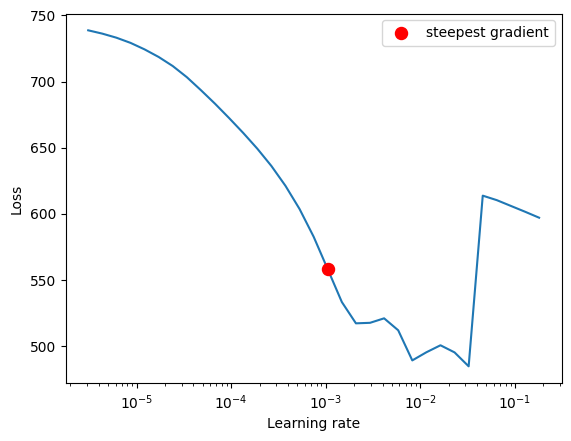

Plot saved to: logs/Regression/boston/CNN/TINTO_blur_Model1/lr_finder_plot.png
Suggested learning rate: 0.0010502110796366674


In [26]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [27]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=1e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.88 seconds
Best model found at epoch 96/100
Best Train Loss: 31.5109, Best Val Loss: 21.2646
Best Train MSE: 30.7463, Best Val MSE: 23.5243
Best Train RMSE: 5.5449, Best Val RMSE: 4.8502
Best model saved to models/Regression/boston/CNN/TINTO_blur_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.57E-02


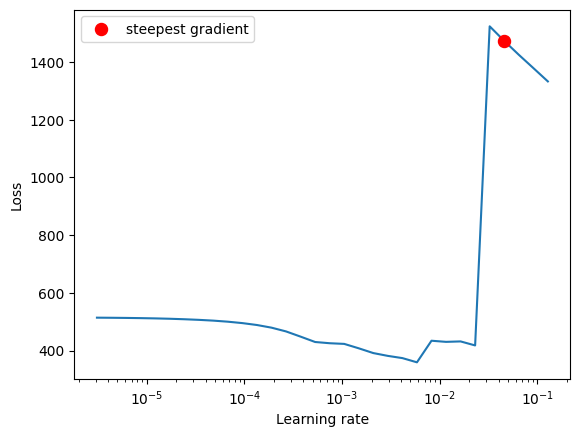

Plot saved to: logs/Regression/boston/CNN/TINTO_blur_Model2/lr_finder_plot.png
Suggested learning rate: 0.04566405432338165


In [28]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [29]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-4, max_lr=1e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.20 seconds
Best model found at epoch 83/100
Best Train Loss: 53.2666, Best Val Loss: 35.8084
Best Train MSE: 52.8992, Best Val MSE: 38.3963
Best Train RMSE: 7.2732, Best Val RMSE: 6.1965
Best model saved to models/Regression/boston/CNN/TINTO_blur_Model2/best_model.pth


Successfully created and tested Model3


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.94E-03


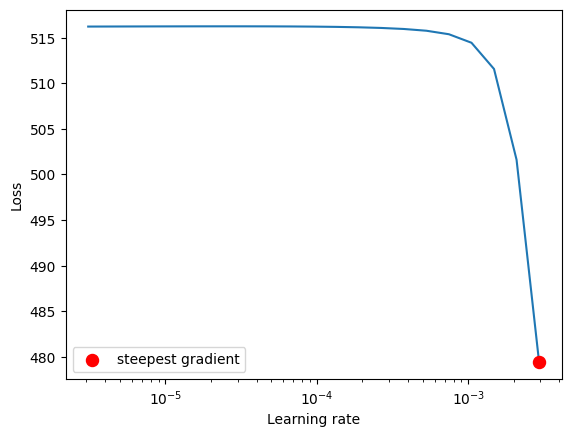

Plot saved to: logs/Regression/boston/CNN/TINTO_blur_Model3/lr_finder_plot.png
Suggested learning rate: 0.0029382253839710104


In [30]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [31]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-3, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 13.16 seconds
Best model found at epoch 92/100
Best Train Loss: 23.5320, Best Val Loss: 14.2781
Best Train MSE: 23.6076, Best Val MSE: 15.0002
Best Train RMSE: 4.8588, Best Val RMSE: 3.8730
Best model saved to models/Regression/boston/CNN/TINTO_blur_Model3/best_model.pth


In [32]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 30.398275228647087, 'train_mse': 30.686731338500977, 'train_mae': 3.755209445953369, 'train_rmse': 5.539560572689947, 'train_r2': 0.6352649927139282, 'val_loss': 21.264589309692383, 'val_mse': 23.52433204650879, 'val_mae': 3.568305492401123, 'val_rmse': 4.850188867096702, 'val_r2': 0.6114627718925476, 'test_loss': 108.58296203613281, 'test_mse': 109.4957275390625, 'test_mae': 6.854118824005127, 'test_rmse': 10.4640206201566, 'test_r2': -0.03139948844909668, 'min_lr': 1e-05, 'max_lr': 0.01, 'total_time': 4.875211715698242, 'average_epoch_time': 0.048749616146087645}
Model 2 Metrics: {'train_loss': 52.224675985483024, 'train_mse': 52.58601379394531, 'train_mae': 4.762672424316406, 'train_rmse': 7.251621459642341, 'train_r2': 0.37497544288635254, 'val_loss': 35.808356285095215, 'val_mse': 38.396339416503906, 'val_mae': 4.679970741271973, 'val_rmse': 6.196477984831699, 'val_r2': 0.36583077907562256, 'test_loss': 80.28863525390625, 'test_mse': 83.088462829589

In [33]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True, option="maximum", random_seed=SEED)
name = f"TINTO_blur_maximum"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [34]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_TINTO_blur_maximum/train/regression.csv
./HyNNImages/Regression/boston/images_boston_TINTO_blur_maximum/val/regression.csv
./HyNNImages/Regression/boston/images_boston_TINTO_blur_maximum/test/regression.csv
Images shape:  (3, 20, 20)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.09E-03


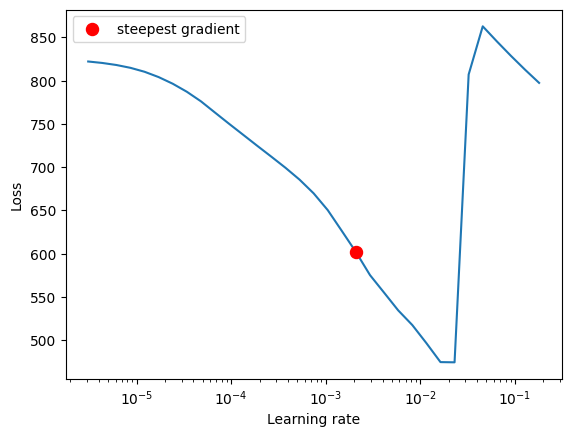

Plot saved to: logs/Regression/boston/CNN/TINTO_blur_maximum_Model1/lr_finder_plot.png
Suggested learning rate: 0.002085205857248754


In [35]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [36]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=1e-1)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 3.53 seconds
Best model found at epoch 17/100
Best Train Loss: 62.9526, Best Val Loss: 34.0596
Best Train MSE: 62.1527, Best Val MSE: 38.0684
Best Train RMSE: 7.8837, Best Val RMSE: 6.1700
Best model saved to models/Regression/boston/CNN/TINTO_blur_maximum_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.75E-04


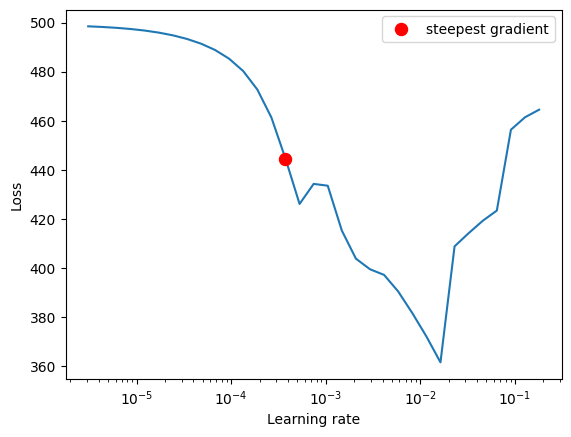

Plot saved to: logs/Regression/boston/CNN/TINTO_blur_maximum_Model2/lr_finder_plot.png
Suggested learning rate: 0.00037537736819256024


In [37]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [38]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=3e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 4.16 seconds
Best model found at epoch 78/100
Best Train Loss: 4.3883, Best Val Loss: 13.4028
Best Train MSE: 4.4396, Best Val MSE: 14.1077
Best Train RMSE: 2.1070, Best Val RMSE: 3.7560
Best model saved to models/Regression/boston/CNN/TINTO_blur_maximum_Model2/best_model.pth


Successfully created and tested Model3


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.05E-03


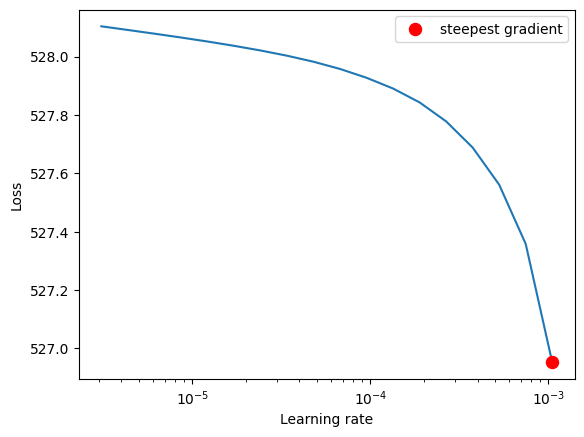

Plot saved to: logs/Regression/boston/CNN/TINTO_blur_maximum_Model3/lr_finder_plot.png
Suggested learning rate: 0.0010502110796366674


In [39]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [40]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-3, max_lr=3e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 12.89 seconds
Best model found at epoch 94/100
Best Train Loss: 19.1100, Best Val Loss: 12.6182
Best Train MSE: 18.9324, Best Val MSE: 13.1428
Best Train RMSE: 4.3511, Best Val RMSE: 3.6253
Best model saved to models/Regression/boston/CNN/TINTO_blur_maximum_Model3/best_model.pth


In [41]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 53.94255432715783, 'train_mse': 53.84184646606445, 'train_mae': 5.013000965118408, 'train_rmse': 7.337700352703458, 'train_r2': 0.36004889011383057, 'val_loss': 34.05955791473389, 'val_mse': 38.06836700439453, 'val_mae': 4.686535835266113, 'val_rmse': 6.169956807336217, 'val_r2': 0.37124770879745483, 'test_loss': 106.02180099487305, 'test_mse': 106.1644058227539, 'test_mae': 7.975351333618164, 'test_rmse': 10.303611300061446, 'test_r2': -1.990795135498047e-05, 'min_lr': 1e-05, 'max_lr': 0.1, 'total_time': 3.526484489440918, 'average_epoch_time': 0.03526198863983154}
Model 2 Metrics: {'train_loss': 4.021185581500713, 'train_mse': 4.073883533477783, 'train_mae': 1.5249860286712646, 'train_rmse': 2.018386368730671, 'train_r2': 0.9515787959098816, 'val_loss': 13.402839660644531, 'val_mse': 14.107660293579102, 'val_mae': 2.726053476333618, 'val_rmse': 3.7560165459671637, 'val_r2': 0.7669922709465027, 'test_loss': 117.3382797241211, 'test_mse': 122.42922973632

In [42]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, random_seed=SEED)
name = f"TINTO"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [43]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_TINTO/train/regression.csv
./HyNNImages/Regression/boston/images_boston_TINTO/val/regression.csv
./HyNNImages/Regression/boston/images_boston_TINTO/test/regression.csv
Images shape:  (3, 20, 20)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.94E-03


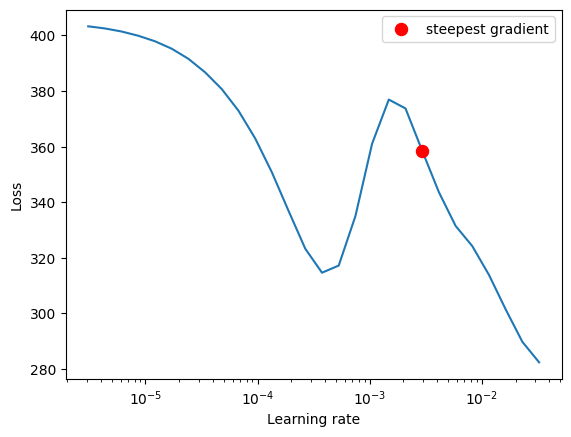

Plot saved to: logs/Regression/boston/CNN/TINTO_Model1/lr_finder_plot.png
Suggested learning rate: 0.0029382253839710104


In [44]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [45]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=1e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.04 seconds
Best model found at epoch 72/100
Best Train Loss: 8.3188, Best Val Loss: 17.3369
Best Train MSE: 8.3560, Best Val MSE: 18.2103
Best Train RMSE: 2.8907, Best Val RMSE: 4.2674
Best model saved to models/Regression/boston/CNN/TINTO_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.75E-04


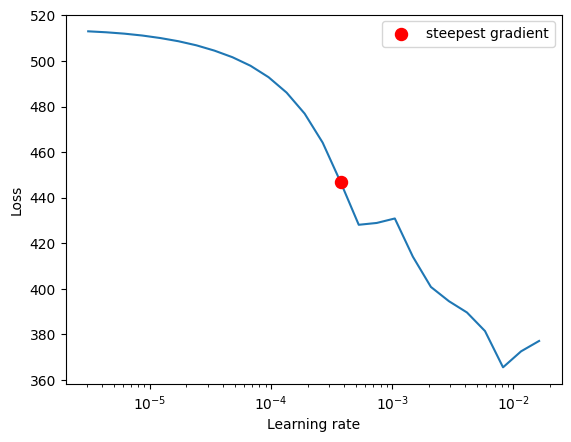

Plot saved to: logs/Regression/boston/CNN/TINTO_Model2/lr_finder_plot.png
Suggested learning rate: 0.00037537736819256024


In [46]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [47]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=4e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 4.36 seconds
Best model found at epoch 62/100
Best Train Loss: 6.3615, Best Val Loss: 13.9488
Best Train MSE: 6.3909, Best Val MSE: 14.8326
Best Train RMSE: 2.5280, Best Val RMSE: 3.8513
Best model saved to models/Regression/boston/CNN/TINTO_Model2/best_model.pth


Successfully created and tested Model3


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.22E-03


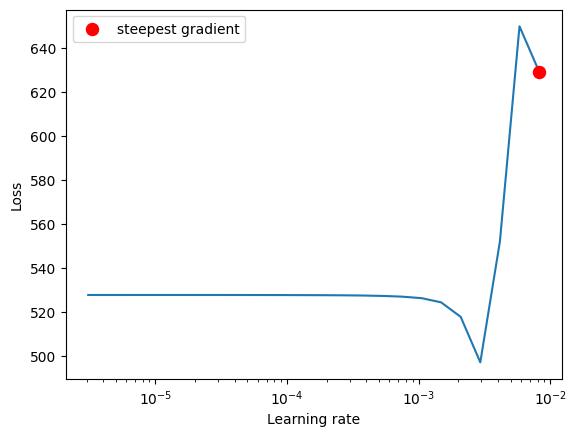

Plot saved to: logs/Regression/boston/CNN/TINTO_Model3/lr_finder_plot.png
Suggested learning rate: 0.008220412614574906


In [48]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [49]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-3, max_lr=3e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 11.66 seconds
Best model found at epoch 100/100
Best Train Loss: 16.6548, Best Val Loss: 13.0077
Best Train MSE: 16.8607, Best Val MSE: 13.7189
Best Train RMSE: 4.1062, Best Val RMSE: 3.7039
Best model saved to models/Regression/boston/CNN/TINTO_Model3/best_model.pth


In [50]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 8.421708803910475, 'train_mse': 8.445494651794434, 'train_mae': 2.038944721221924, 'train_rmse': 2.9061133239766193, 'train_r2': 0.899618923664093, 'val_loss': 17.336944580078125, 'val_mse': 18.210302352905273, 'val_mae': 3.0790369510650635, 'val_rmse': 4.267353085099154, 'val_r2': 0.6992313861846924, 'test_loss': 531.964599609375, 'test_mse': 521.5514526367188, 'test_mae': 19.92801856994629, 'test_rmse': 22.837501015582216, 'test_r2': -3.9127750396728516, 'min_lr': 1e-05, 'max_lr': 0.01, 'total_time': 4.039599657058716, 'average_epoch_time': 0.0403937029838562}
Model 2 Metrics: {'train_loss': 5.625958534387442, 'train_mse': 5.640401363372803, 'train_mae': 1.6729655265808105, 'train_rmse': 2.3749529181381264, 'train_r2': 0.9329595565795898, 'val_loss': 13.948847770690918, 'val_mse': 14.832609176635742, 'val_mae': 2.6621642112731934, 'val_rmse': 3.851312656307683, 'val_r2': 0.7550187110900879, 'test_loss': 108.38406372070312, 'test_mse': 113.8885574340820

### EXPERIMENT 2: IGTD

In [51]:
# Get the shape of the dataframe
num_columns = df.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

4


In [52]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', error='abs', max_step=30000, val_step=300, random_seed=SEED)
name = f"IGTD_{image_size}x{image_size}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [53]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_IGTD_4x4_fEuclidean_iEuclidean_abs/train/regression.csv
./HyNNImages/Regression/boston/images_boston_IGTD_4x4_fEuclidean_iEuclidean_abs/val/regression.csv
./HyNNImages/Regression/boston/images_boston_IGTD_4x4_fEuclidean_iEuclidean_abs/test/regression.csv
Images shape:  (3, 4, 4)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.83E-03


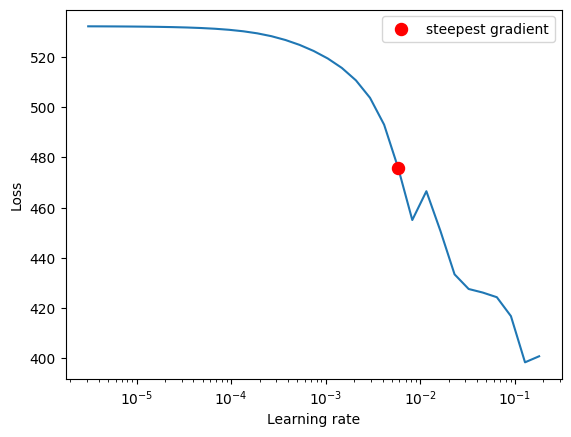

Plot saved to: logs/Regression/boston/CNN/IGTD_4x4_fEuclidean_iEuclidean_abs_Model1/lr_finder_plot.png
Suggested learning rate: 0.005833879397552116


In [54]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [55]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-3, max_lr=1e-1)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 5.71 seconds
Best model found at epoch 14/100
Best Train Loss: 26.9294, Best Val Loss: 17.8238
Best Train MSE: 26.9714, Best Val MSE: 18.0086
Best Train RMSE: 5.1934, Best Val RMSE: 4.2437
Best model saved to models/Regression/boston/CNN/IGTD_4x4_fEuclidean_iEuclidean_abs_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.16E-02


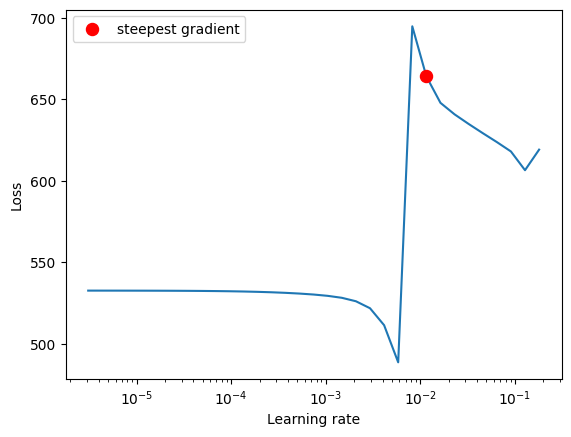

Plot saved to: logs/Regression/boston/CNN/IGTD_4x4_fEuclidean_iEuclidean_abs_Model2/lr_finder_plot.png
Suggested learning rate: 0.011583232862547112


In [56]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [57]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-3, max_lr=1e-1)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 7.38 seconds
Best model found at epoch 12/100
Best Train Loss: 25.3411, Best Val Loss: 22.2762
Best Train MSE: 25.4482, Best Val MSE: 23.0634
Best Train RMSE: 5.0446, Best Val RMSE: 4.8024
Best model saved to models/Regression/boston/CNN/IGTD_4x4_fEuclidean_iEuclidean_abs_Model2/best_model.pth


In [58]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small


Traceback (most recent call last):
  File "/tmp/ipykernel_9874/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10

In [59]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-5, max_lr=4e-4)  # Train and evaluate Model3

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small
Model IGTD_4x4_fEuclidean_iEuclidean_abs_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_9874/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10

In [60]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 22.203405526968147, 'train_mse': 22.38494873046875, 'train_mae': 3.5779805183410645, 'train_rmse': 4.731273478723118, 'train_r2': 0.7339379787445068, 'val_loss': 17.82383632659912, 'val_mse': 18.00857925415039, 'val_mae': 3.3718318939208984, 'val_rmse': 4.243651641469925, 'val_r2': 0.7025631666183472, 'test_loss': 197.30756378173828, 'test_mse': 192.45521545410156, 'test_mae': 9.878595352172852, 'test_rmse': 13.872822908626116, 'test_r2': -0.8128396272659302, 'min_lr': 0.001, 'max_lr': 0.1, 'total_time': 5.713650941848755, 'average_epoch_time': 0.05713423490524292}
Model 2 Metrics: {'train_loss': 27.11104943202092, 'train_mse': 27.433523178100586, 'train_mae': 3.8090052604675293, 'train_rmse': 5.237702089475936, 'train_r2': 0.6739318370819092, 'val_loss': 22.276168823242188, 'val_mse': 23.063426971435547, 'val_mae': 3.519209861755371, 'val_rmse': 4.802439689515689, 'val_r2': 0.6190752983093262, 'test_loss': 98.51324462890625, 'test_mse': 104.309608459472

In [61]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', zoom=2, random_seed=SEED)
name = f"IGTD_{image_size*2}x{image_size*2}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [62]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_IGTD_8x8_fEuclidean_iEuclidean_abs/train/regression.csv
./HyNNImages/Regression/boston/images_boston_IGTD_8x8_fEuclidean_iEuclidean_abs/val/regression.csv
./HyNNImages/Regression/boston/images_boston_IGTD_8x8_fEuclidean_iEuclidean_abs/test/regression.csv
Images shape:  (3, 8, 8)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.45E-04


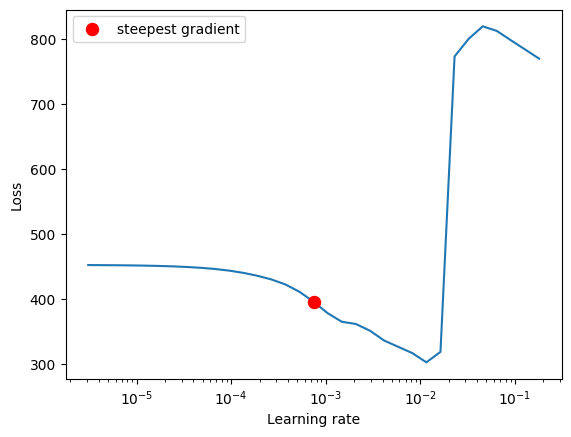

Plot saved to: logs/Regression/boston/CNN/IGTD_8x8_fEuclidean_iEuclidean_abs_Model1/lr_finder_plot.png
Suggested learning rate: 0.0007453159674382293


In [63]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [64]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-4, max_lr=2e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 5.99 seconds
Best model found at epoch 11/100
Best Train Loss: 19.8627, Best Val Loss: 19.0727
Best Train MSE: 18.3929, Best Val MSE: 19.2203
Best Train RMSE: 4.2887, Best Val RMSE: 4.3841
Best model saved to models/Regression/boston/CNN/IGTD_8x8_fEuclidean_iEuclidean_abs_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.05E-03


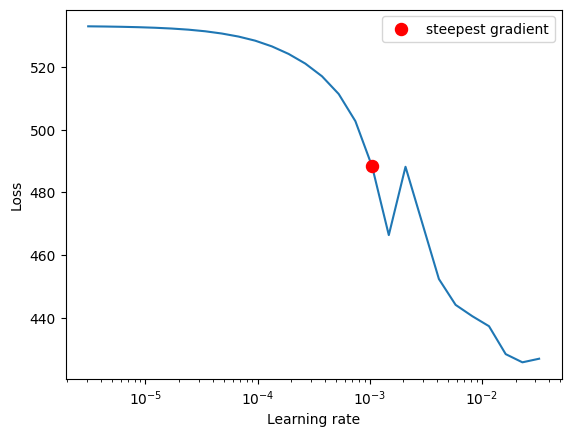

Plot saved to: logs/Regression/boston/CNN/IGTD_8x8_fEuclidean_iEuclidean_abs_Model2/lr_finder_plot.png
Suggested learning rate: 0.0010502110796366674


In [65]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [66]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-4, max_lr=1e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 7.21 seconds
Best model found at epoch 14/100
Best Train Loss: 25.0317, Best Val Loss: 19.7563
Best Train MSE: 25.0485, Best Val MSE: 19.7949
Best Train RMSE: 5.0048, Best Val RMSE: 4.4491
Best model saved to models/Regression/boston/CNN/IGTD_8x8_fEuclidean_iEuclidean_abs_Model2/best_model.pth


In [67]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small


Traceback (most recent call last):
  File "/tmp/ipykernel_9874/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10

In [68]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-3, max_lr=6e-2)  # Train and evaluate Model3

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small
Model IGTD_8x8_fEuclidean_iEuclidean_abs_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_9874/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10

In [69]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 15.374091881972094, 'train_mse': 15.44986629486084, 'train_mae': 2.6615872383117676, 'train_rmse': 3.9306317933458024, 'train_r2': 0.8163666725158691, 'val_loss': 19.072726249694824, 'val_mse': 19.220285415649414, 'val_mae': 3.0511815547943115, 'val_rmse': 4.384094594742387, 'val_r2': 0.6825500726699829, 'test_loss': 35.08040523529053, 'test_mse': 39.49864196777344, 'test_mae': 3.794856071472168, 'test_rmse': 6.28479450481664, 'test_r2': 0.6279408931732178, 'min_lr': 0.0001, 'max_lr': 0.02, 'total_time': 5.98612117767334, 'average_epoch_time': 0.05985844850540161}
Model 2 Metrics: {'train_loss': 17.437945035787727, 'train_mse': 17.49041175842285, 'train_mae': 2.690948724746704, 'train_rmse': 4.182153961587599, 'train_r2': 0.7921132445335388, 'val_loss': 19.756309509277344, 'val_mse': 19.794919967651367, 'val_mae': 3.0020315647125244, 'val_rmse': 4.449148229453742, 'val_r2': 0.6730592250823975, 'test_loss': 56.00734519958496, 'test_mse': 60.84423828125, '

In [70]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', zoom=4, random_seed=SEED)
name = f"IGTD_{image_size*4}x{image_size*4}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [71]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_IGTD_16x16_fEuclidean_iEuclidean_abs/train/regression.csv
./HyNNImages/Regression/boston/images_boston_IGTD_16x16_fEuclidean_iEuclidean_abs/val/regression.csv
./HyNNImages/Regression/boston/images_boston_IGTD_16x16_fEuclidean_iEuclidean_abs/test/regression.csv
Images shape:  (3, 16, 16)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.48E-03


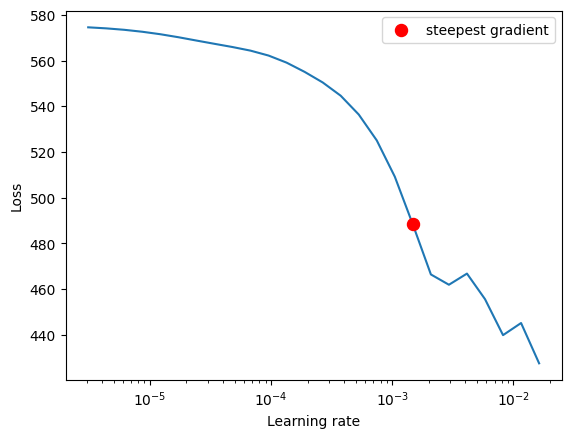

Plot saved to: logs/Regression/boston/CNN/IGTD_16x16_fEuclidean_iEuclidean_abs_Model1/lr_finder_plot.png
Suggested learning rate: 0.0014798331982375287


In [72]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [73]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=4e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 6.01 seconds
Best model found at epoch 18/100
Best Train Loss: 14.9319, Best Val Loss: 19.4291
Best Train MSE: 14.9001, Best Val MSE: 19.7815
Best Train RMSE: 3.8601, Best Val RMSE: 4.4476
Best model saved to models/Regression/boston/CNN/IGTD_16x16_fEuclidean_iEuclidean_abs_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.75E-04


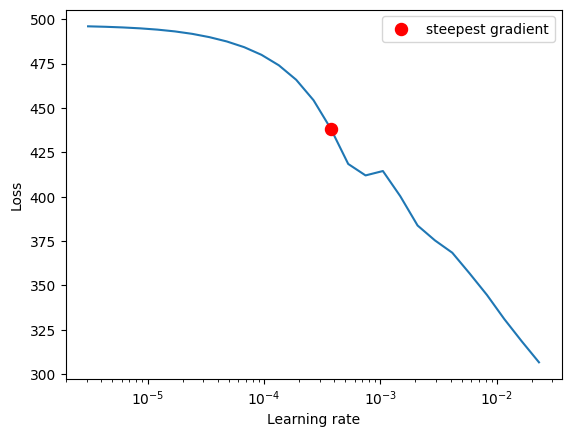

Plot saved to: logs/Regression/boston/CNN/IGTD_16x16_fEuclidean_iEuclidean_abs_Model2/lr_finder_plot.png
Suggested learning rate: 0.00037537736819256024


In [74]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [75]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=1e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 7.39 seconds
Best model found at epoch 11/100
Best Train Loss: 13.7214, Best Val Loss: 16.4250
Best Train MSE: 14.0419, Best Val MSE: 16.9226
Best Train RMSE: 3.7472, Best Val RMSE: 4.1137
Best model saved to models/Regression/boston/CNN/IGTD_16x16_fEuclidean_iEuclidean_abs_Model2/best_model.pth


Successfully created and tested Model3


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.05E-03


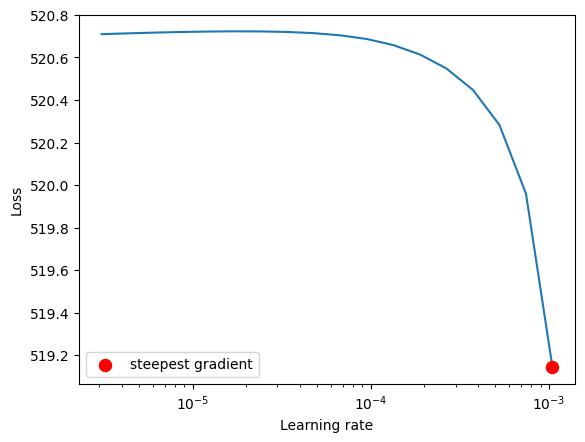

Plot saved to: logs/Regression/boston/CNN/IGTD_16x16_fEuclidean_iEuclidean_abs_Model3/lr_finder_plot.png
Suggested learning rate: 0.0010502110796366674


In [76]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [77]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-5, max_lr=1e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 17.40 seconds
Best model found at epoch 25/100
Best Train Loss: 33.0717, Best Val Loss: 18.6642
Best Train MSE: 33.4388, Best Val MSE: 19.2460
Best Train RMSE: 5.7826, Best Val RMSE: 4.3870
Best model saved to models/Regression/boston/CNN/IGTD_16x16_fEuclidean_iEuclidean_abs_Model3/best_model.pth


In [78]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 12.710546016693115, 'train_mse': 12.879018783569336, 'train_mae': 2.5272274017333984, 'train_rmse': 3.5887349837469658, 'train_r2': 0.8469231128692627, 'val_loss': 19.42909049987793, 'val_mse': 19.781538009643555, 'val_mae': 3.1780707836151123, 'val_rmse': 4.447644096557587, 'val_r2': 0.6732802391052246, 'test_loss': 28.827482223510742, 'test_mse': 32.291534423828125, 'test_mae': 3.4579803943634033, 'test_rmse': 5.682564071247074, 'test_r2': 0.6958285570144653, 'min_lr': 1e-05, 'max_lr': 0.04, 'total_time': 6.0102760791778564, 'average_epoch_time': 0.0601004695892334}
Model 2 Metrics: {'train_loss': 12.936854179088886, 'train_mse': 13.1068115234375, 'train_mae': 2.320875406265259, 'train_rmse': 3.6203330680253027, 'train_r2': 0.8442156314849854, 'val_loss': 16.425029277801514, 'val_mse': 16.922605514526367, 'val_mae': 2.901761293411255, 'val_rmse': 4.113709459177492, 'val_r2': 0.7204995155334473, 'test_loss': 35.443970680236816, 'test_mse': 39.1876106262

### EXPERIMENT 3: REFINED

In [79]:
#Select the model and the parameters
problem_type = "regression"
image_model = REFINED(problem= problem_type, random_seed=SEED)
name = f"REFINED"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [80]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_REFINED/train/regression.csv
./HyNNImages/Regression/boston/images_boston_REFINED/val/regression.csv
./HyNNImages/Regression/boston/images_boston_REFINED/test/regression.csv
Images shape:  (3, 4, 4)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.14E-03


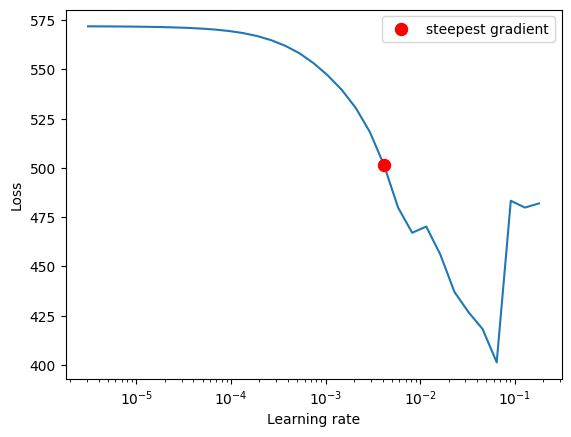

Plot saved to: logs/Regression/boston/CNN/REFINED_Model1/lr_finder_plot.png
Suggested learning rate: 0.00414019957645922


In [81]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [82]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-3, max_lr=8e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 6.02 seconds
Best model found at epoch 80/100
Best Train Loss: 15.3940, Best Val Loss: 17.5839
Best Train MSE: 15.6114, Best Val MSE: 19.0931
Best Train RMSE: 3.9511, Best Val RMSE: 4.3696
Best model saved to models/Regression/boston/CNN/REFINED_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.63E-02


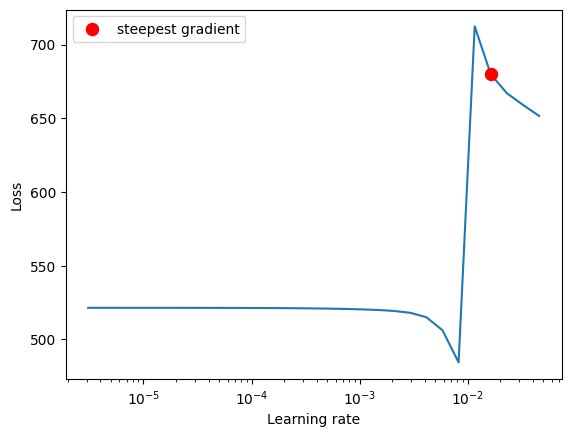

Plot saved to: logs/Regression/boston/CNN/REFINED_Model2/lr_finder_plot.png
Suggested learning rate: 0.01632172128563274


In [83]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [84]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-3, max_lr=7e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 7.23 seconds
Best model found at epoch 57/100
Best Train Loss: 24.3826, Best Val Loss: 21.7078
Best Train MSE: 23.8817, Best Val MSE: 23.9298
Best Train RMSE: 4.8869, Best Val RMSE: 4.8918
Best model saved to models/Regression/boston/CNN/REFINED_Model2/best_model.pth


In [85]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small


Traceback (most recent call last):
  File "/tmp/ipykernel_9874/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10

In [86]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-5, max_lr=6e-4)  # Train and evaluate Model3

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small
Model REFINED_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_9874/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10

In [87]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 15.539873159848726, 'train_mse': 15.811324119567871, 'train_mae': 2.992581605911255, 'train_rmse': 3.9763455734591115, 'train_r2': 0.8120704889297485, 'val_loss': 17.58392906188965, 'val_mse': 19.093103408813477, 'val_mae': 3.263805866241455, 'val_rmse': 4.369565585823547, 'val_r2': 0.6846506595611572, 'test_loss': 471.9269714355469, 'test_mse': 464.2234191894531, 'test_mae': 18.80238914489746, 'test_rmse': 21.545844592158673, 'test_r2': -3.3727712631225586, 'min_lr': 0.001, 'max_lr': 0.08, 'total_time': 6.021870851516724, 'average_epoch_time': 0.06021639108657837}
Model 2 Metrics: {'train_loss': 19.51264161330003, 'train_mse': 19.704057693481445, 'train_mae': 3.1269216537475586, 'train_rmse': 4.438925285863848, 'train_r2': 0.7658023834228516, 'val_loss': 21.707765102386475, 'val_mse': 23.929798126220703, 'val_mae': 3.740952968597412, 'val_rmse': 4.8918092896412775, 'val_r2': 0.6047659516334534, 'test_loss': 3045.3804931640625, 'test_mse': 3032.893310546

In [88]:
#Select the model and the parameters
problem_type = "regression"
image_model = REFINED(problem= problem_type, zoom=2, random_seed=SEED)
name = f"REFINED_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [89]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_REFINED_zoom2/train/regression.csv
./HyNNImages/Regression/boston/images_boston_REFINED_zoom2/val/regression.csv
./HyNNImages/Regression/boston/images_boston_REFINED_zoom2/test/regression.csv
Images shape:  (3, 8, 8)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.14E-03


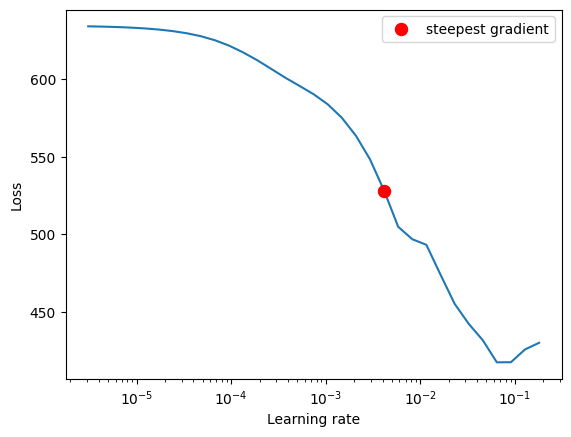

Plot saved to: logs/Regression/boston/CNN/REFINED_zoom2_Model1/lr_finder_plot.png
Suggested learning rate: 0.00414019957645922


In [90]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [91]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=2e-4, max_lr=4e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 5.74 seconds
Best model found at epoch 92/100
Best Train Loss: 15.2457, Best Val Loss: 19.4817
Best Train MSE: 14.4551, Best Val MSE: 20.7295
Best Train RMSE: 3.8020, Best Val RMSE: 4.5530
Best model saved to models/Regression/boston/CNN/REFINED_zoom2_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.14E-03


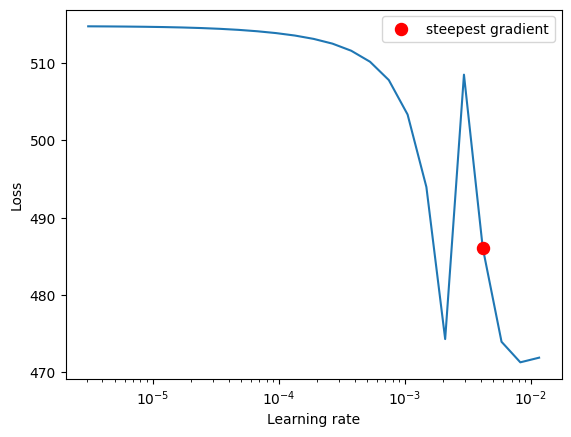

Plot saved to: logs/Regression/boston/CNN/REFINED_zoom2_Model2/lr_finder_plot.png
Suggested learning rate: 0.00414019957645922


In [92]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [93]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-3, max_lr=2e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 7.24 seconds
Best model found at epoch 95/100
Best Train Loss: 12.3971, Best Val Loss: 18.9952
Best Train MSE: 12.3737, Best Val MSE: 20.3057
Best Train RMSE: 3.5176, Best Val RMSE: 4.5062
Best model saved to models/Regression/boston/CNN/REFINED_zoom2_Model2/best_model.pth


In [94]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small


Traceback (most recent call last):
  File "/tmp/ipykernel_9874/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10

In [95]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-3, max_lr=9e-2)  # Train and evaluate Model3

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small
Model REFINED_zoom2_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_9874/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10

In [96]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 14.177403743450459, 'train_mse': 14.337356567382812, 'train_mae': 2.712663412094116, 'train_rmse': 3.786470198929712, 'train_r2': 0.8295896649360657, 'val_loss': 19.481672763824463, 'val_mse': 20.729467391967773, 'val_mae': 3.403761863708496, 'val_rmse': 4.552962485236153, 'val_r2': 0.6576238870620728, 'test_loss': 254.66687774658203, 'test_mse': 254.3190155029297, 'test_mae': 12.698087692260742, 'test_rmse': 15.947382716387342, 'test_r2': -1.3955681324005127, 'min_lr': 0.0002, 'max_lr': 0.04, 'total_time': 5.7442708015441895, 'average_epoch_time': 0.05744035243988037}
Model 2 Metrics: {'train_loss': 11.142158801739033, 'train_mse': 11.205196380615234, 'train_mae': 2.3318591117858887, 'train_rmse': 3.3474163739539833, 'train_r2': 0.8668177723884583, 'val_loss': 18.995230197906494, 'val_mse': 20.30565643310547, 'val_mae': 3.4082863330841064, 'val_rmse': 4.5061798047909125, 'val_r2': 0.6646236777305603, 'test_loss': 105.40376663208008, 'test_mse': 104.4042

In [97]:
#Select the model and the parameters
problem_type = "regression"
image_model = REFINED(problem= problem_type, zoom=4, random_seed=SEED)
name = f"REFINED_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [98]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_REFINED_zoom4/train/regression.csv
./HyNNImages/Regression/boston/images_boston_REFINED_zoom4/val/regression.csv
./HyNNImages/Regression/boston/images_boston_REFINED_zoom4/test/regression.csv
Images shape:  (3, 16, 16)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.66E-04


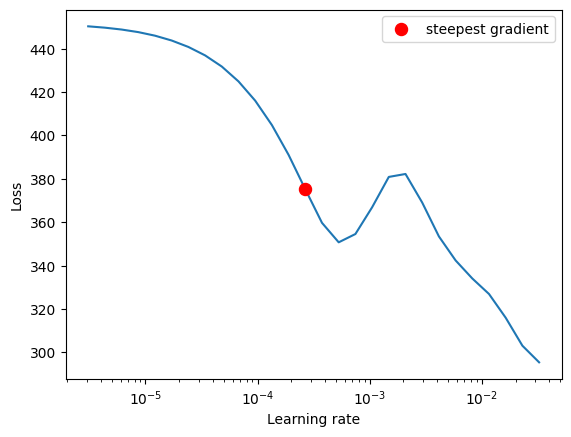

Plot saved to: logs/Regression/boston/CNN/REFINED_zoom4_Model1/lr_finder_plot.png
Suggested learning rate: 0.00026639858572587714


In [99]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [100]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=5e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 6.20 seconds
Best model found at epoch 21/100
Best Train Loss: 60.2427, Best Val Loss: 29.4658
Best Train MSE: 60.3894, Best Val MSE: 30.7698
Best Train RMSE: 7.7711, Best Val RMSE: 5.5471
Best model saved to models/Regression/boston/CNN/REFINED_zoom4_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.94E-03


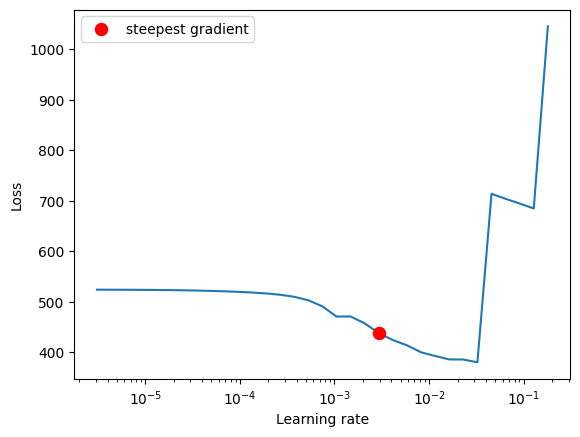

Plot saved to: logs/Regression/boston/CNN/REFINED_zoom4_Model2/lr_finder_plot.png
Suggested learning rate: 0.0029382253839710104


In [101]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [102]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-4, max_lr=4e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 7.32 seconds
Best model found at epoch 15/100
Best Train Loss: 76.2178, Best Val Loss: 38.2566
Best Train MSE: 76.8952, Best Val MSE: 40.7075
Best Train RMSE: 8.7690, Best Val RMSE: 6.3802
Best model saved to models/Regression/boston/CNN/REFINED_zoom4_Model2/best_model.pth


Successfully created and tested Model3


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.22E-03


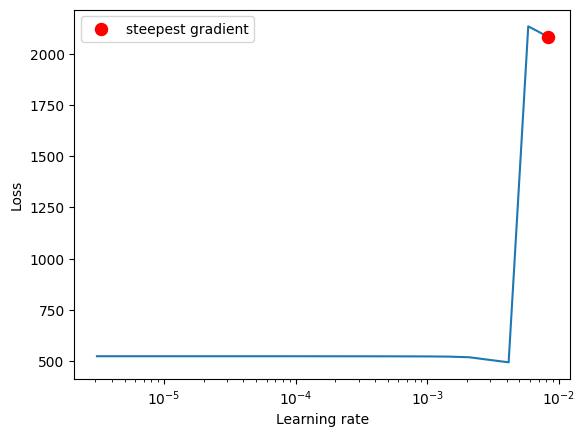

Plot saved to: logs/Regression/boston/CNN/REFINED_zoom4_Model3/lr_finder_plot.png
Suggested learning rate: 0.008220412614574906


In [103]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [104]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=3e-5, max_lr=1e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 17.30 seconds
Best model found at epoch 84/100
Best Train Loss: 29.7582, Best Val Loss: 22.6769
Best Train MSE: 29.9321, Best Val MSE: 24.5866
Best Train RMSE: 5.4710, Best Val RMSE: 4.9585
Best model saved to models/Regression/boston/CNN/REFINED_zoom4_Model3/best_model.pth


In [105]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 31.357537049513596, 'train_mse': 31.756498336791992, 'train_mae': 3.840604066848755, 'train_rmse': 5.635290439435397, 'train_r2': 0.6225500106811523, 'val_loss': 29.465785026550293, 'val_mse': 30.76982307434082, 'val_mae': 3.950697422027588, 'val_rmse': 5.547055351656482, 'val_r2': 0.49179333448410034, 'test_loss': 106.56550216674805, 'test_mse': 107.11429595947266, 'test_mae': 8.272343635559082, 'test_rmse': 10.34960366195115, 'test_r2': -0.008967399597167969, 'min_lr': 1e-05, 'max_lr': 0.05, 'total_time': 6.203189134597778, 'average_epoch_time': 0.06202911138534546}
Model 2 Metrics: {'train_loss': 59.519149193396935, 'train_mse': 59.9708366394043, 'train_mae': 5.572824478149414, 'train_rmse': 7.7440839767789384, 'train_r2': 0.2872012257575989, 'val_loss': 38.256595611572266, 'val_mse': 40.70746994018555, 'val_mae': 5.02634334564209, 'val_rmse': 6.3802405863874405, 'val_r2': 0.3276591897010803, 'test_loss': 226.67076110839844, 'test_mse': 225.2198791503

### EXPERIMENT 4: BAR GRAPH

In [106]:
#Select the model and the parameters
problem_type = "regression"
image_model = BarGraph(problem = problem_type)
name = f"BarGraph"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [107]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_BarGraph/train/regression.csv
./HyNNImages/Regression/boston/images_boston_BarGraph/val/regression.csv
./HyNNImages/Regression/boston/images_boston_BarGraph/test/regression.csv
Images shape:  (3, 13, 13)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.83E-03


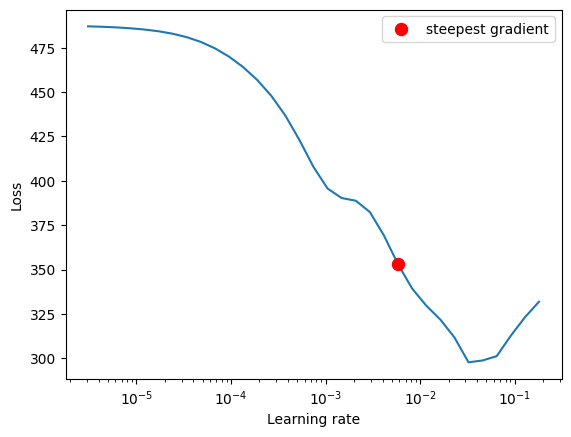

Plot saved to: logs/Regression/boston/CNN/BarGraph_Model1/lr_finder_plot.png
Suggested learning rate: 0.005833879397552116


In [108]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [109]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=6e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 6.10 seconds
Best model found at epoch 8/100
Best Train Loss: 26.7409, Best Val Loss: 19.8149
Best Train MSE: 27.0365, Best Val MSE: 20.9186
Best Train RMSE: 5.1997, Best Val RMSE: 4.5737
Best model saved to models/Regression/boston/CNN/BarGraph_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.45E-04


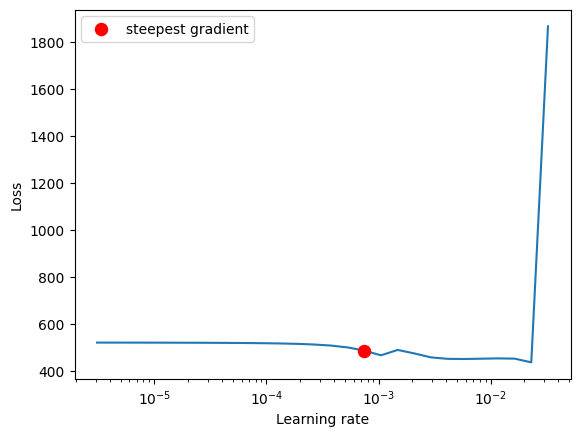

Plot saved to: logs/Regression/boston/CNN/BarGraph_Model2/lr_finder_plot.png
Suggested learning rate: 0.0007453159674382293


In [110]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [111]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-4, max_lr=7e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 7.22 seconds
Best model found at epoch 14/100
Best Train Loss: 18.5578, Best Val Loss: 16.3246
Best Train MSE: 18.1504, Best Val MSE: 17.1878
Best Train RMSE: 4.2603, Best Val RMSE: 4.1458
Best model saved to models/Regression/boston/CNN/BarGraph_Model2/best_model.pth


In [112]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small


Traceback (most recent call last):
  File "/tmp/ipykernel_9874/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10

In [113]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-3, max_lr=6e-2)  # Train and evaluate Model3

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small
Model BarGraph_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_9874/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10

In [114]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 23.793002348679764, 'train_mse': 23.958633422851562, 'train_mae': 3.846545457839966, 'train_rmse': 4.894755706146279, 'train_r2': 0.715233564376831, 'val_loss': 19.814850330352783, 'val_mse': 20.918577194213867, 'val_mae': 3.5874905586242676, 'val_rmse': 4.573683110384219, 'val_r2': 0.6545004844665527, 'test_loss': 23.47117567062378, 'test_mse': 27.635297775268555, 'test_mae': 2.982659101486206, 'test_rmse': 5.256928549568517, 'test_r2': 0.7396881580352783, 'min_lr': 1e-05, 'max_lr': 0.06, 'total_time': 6.1012959480285645, 'average_epoch_time': 0.06101054191589356}
Model 2 Metrics: {'train_loss': 12.817446928757887, 'train_mse': 13.028514862060547, 'train_mae': 2.4785735607147217, 'train_rmse': 3.60950340934325, 'train_r2': 0.8451462388038635, 'val_loss': 16.324604988098145, 'val_mse': 17.18781280517578, 'val_mae': 2.950256109237671, 'val_rmse': 4.14581871349626, 'val_r2': 0.7161192297935486, 'test_loss': 53.12522888183594, 'test_mse': 57.833499908447266

In [115]:
#Select the model and the parameters
problem_type = "regression"
image_model = BarGraph(problem= problem_type, zoom=2)
name = f"BarGraph_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [116]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_BarGraph_zoom2/train/regression.csv
./HyNNImages/Regression/boston/images_boston_BarGraph_zoom2/val/regression.csv
./HyNNImages/Regression/boston/images_boston_BarGraph_zoom2/test/regression.csv
Images shape:  (3, 26, 26)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.76E-05


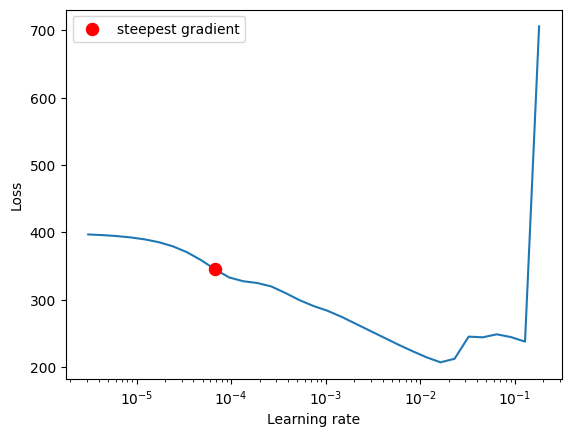

Plot saved to: logs/Regression/boston/CNN/BarGraph_zoom2_Model1/lr_finder_plot.png
Suggested learning rate: 6.757518355386218e-05


In [117]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [118]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=5e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.42 seconds
Best model found at epoch 19/100
Best Train Loss: 21.9795, Best Val Loss: 21.4331
Best Train MSE: 22.3393, Best Val MSE: 21.1970
Best Train RMSE: 4.7264, Best Val RMSE: 4.6040
Best model saved to models/Regression/boston/CNN/BarGraph_zoom2_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.45E-04


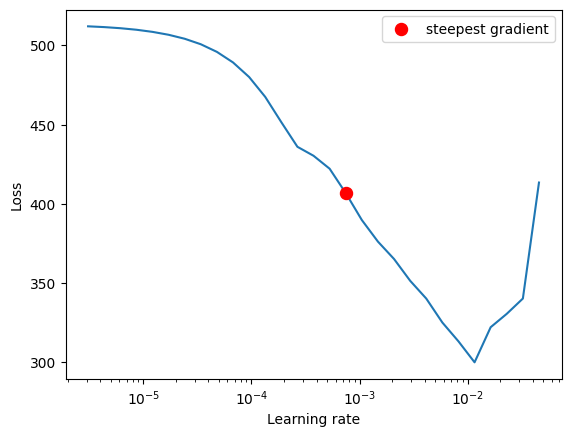

Plot saved to: logs/Regression/boston/CNN/BarGraph_zoom2_Model2/lr_finder_plot.png
Suggested learning rate: 0.0007453159674382293


In [119]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [120]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=5e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 4.63 seconds
Best model found at epoch 13/100
Best Train Loss: 12.3895, Best Val Loss: 16.9196
Best Train MSE: 12.4031, Best Val MSE: 17.3690
Best Train RMSE: 3.5218, Best Val RMSE: 4.1676
Best model saved to models/Regression/boston/CNN/BarGraph_zoom2_Model2/best_model.pth


Successfully created and tested Model3


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.22E-03


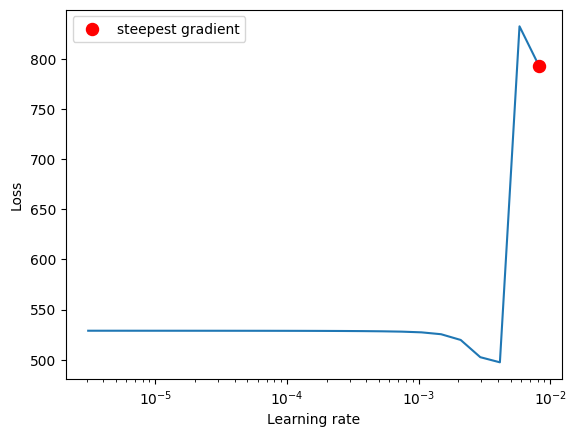

Plot saved to: logs/Regression/boston/CNN/BarGraph_zoom2_Model3/lr_finder_plot.png
Suggested learning rate: 0.008220412614574906


In [121]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [122]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-4, max_lr=1e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 13.17 seconds
Best model found at epoch 8/100
Best Train Loss: 50.1129, Best Val Loss: 19.5785
Best Train MSE: 50.6584, Best Val MSE: 20.9058
Best Train RMSE: 7.1175, Best Val RMSE: 4.5723
Best model saved to models/Regression/boston/CNN/BarGraph_zoom2_Model3/best_model.pth


In [123]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 17.306126374464768, 'train_mse': 17.53331756591797, 'train_mae': 3.279987096786499, 'train_rmse': 4.187280449876503, 'train_r2': 0.7916032671928406, 'val_loss': 21.433125495910645, 'val_mse': 21.19701385498047, 'val_mae': 3.3727121353149414, 'val_rmse': 4.604021487241395, 'val_r2': 0.6499016880989075, 'test_loss': 24.520100593566895, 'test_mse': 26.946880340576172, 'test_mae': 3.4965641498565674, 'test_rmse': 5.191038464563345, 'test_r2': 0.7461727857589722, 'min_lr': 1e-05, 'max_lr': 0.05, 'total_time': 4.41766095161438, 'average_epoch_time': 0.0441737174987793}
Model 2 Metrics: {'train_loss': 8.423637866973877, 'train_mse': 8.56093978881836, 'train_mae': 2.0306034088134766, 'train_rmse': 2.925908369860266, 'train_r2': 0.8982467651367188, 'val_loss': 16.91963005065918, 'val_mse': 17.368959426879883, 'val_mae': 2.891023635864258, 'val_rmse': 4.167608358144978, 'val_r2': 0.7131273746490479, 'test_loss': 23.775705337524414, 'test_mse': 25.57999038696289, '

In [124]:
#Select the model and the parameters
problem_type = "regression"
image_model = BarGraph(problem= problem_type, zoom=4)
name = f"BarGraph_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [125]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_BarGraph_zoom4/train/regression.csv
./HyNNImages/Regression/boston/images_boston_BarGraph_zoom4/val/regression.csv
./HyNNImages/Regression/boston/images_boston_BarGraph_zoom4/test/regression.csv
Images shape:  (3, 52, 52)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.75E-04


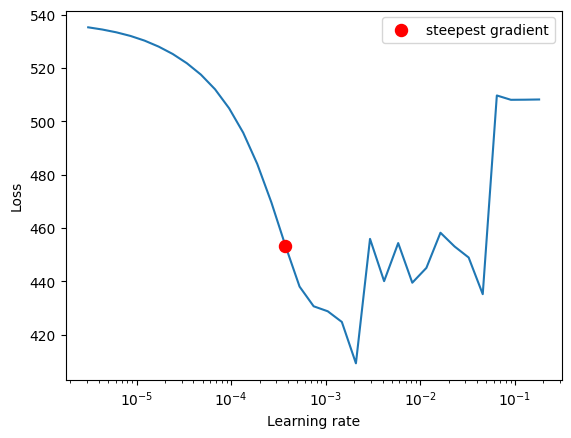

Plot saved to: logs/Regression/boston/CNN/BarGraph_zoom4_Model1/lr_finder_plot.png
Suggested learning rate: 0.00037537736819256024


In [126]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [127]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=5e-6, max_lr=1e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 3.71 seconds
Best model found at epoch 5/100
Best Train Loss: 58.9854, Best Val Loss: 21.4037
Best Train MSE: 59.3333, Best Val MSE: 21.4636
Best Train RMSE: 7.7028, Best Val RMSE: 4.6329
Best model saved to models/Regression/boston/CNN/BarGraph_zoom4_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.29E-04


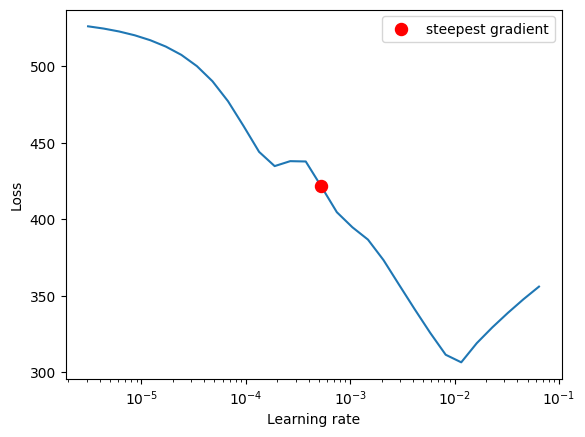

Plot saved to: logs/Regression/boston/CNN/BarGraph_zoom4_Model2/lr_finder_plot.png
Suggested learning rate: 0.0005289373746757308


In [128]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [129]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=4e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 4.55 seconds
Best model found at epoch 8/100
Best Train Loss: 19.8466, Best Val Loss: 15.6870
Best Train MSE: 20.1121, Best Val MSE: 16.2345
Best Train RMSE: 4.4846, Best Val RMSE: 4.0292
Best model saved to models/Regression/boston/CNN/BarGraph_zoom4_Model2/best_model.pth


Successfully created and tested Model3


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.83E-03


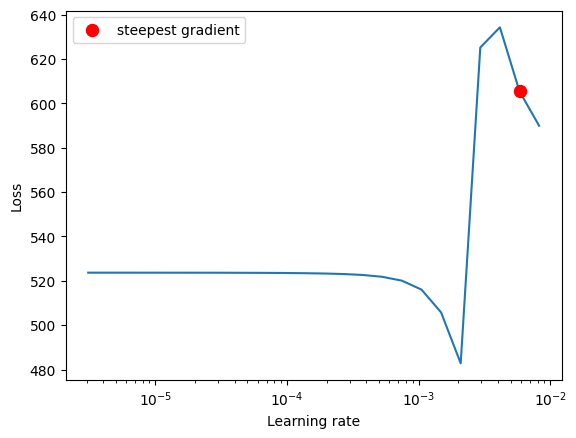

Plot saved to: logs/Regression/boston/CNN/BarGraph_zoom4_Model3/lr_finder_plot.png
Suggested learning rate: 0.005833879397552116


In [130]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [131]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-3, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 13.95 seconds
Best model found at epoch 62/100
Best Train Loss: 31.7051, Best Val Loss: 26.1097
Best Train MSE: 31.6156, Best Val MSE: 26.3675
Best Train RMSE: 5.6228, Best Val RMSE: 5.1349
Best model saved to models/Regression/boston/CNN/BarGraph_zoom4_Model3/best_model.pth


In [132]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 44.02100137563852, 'train_mse': 44.028038024902344, 'train_mae': 5.279399394989014, 'train_rmse': 6.635362689778332, 'train_r2': 0.47669345140457153, 'val_loss': 21.403712272644043, 'val_mse': 21.463642120361328, 'val_mae': 3.5653069019317627, 'val_rmse': 4.632887017871397, 'val_r2': 0.6454979181289673, 'test_loss': 40.451284408569336, 'test_mse': 43.724334716796875, 'test_mae': 4.661250591278076, 'test_rmse': 6.61243787999531, 'test_r2': 0.5881368517875671, 'min_lr': 5e-06, 'max_lr': 0.01, 'total_time': 3.7123913764953613, 'average_epoch_time': 0.03712102174758911}
Model 2 Metrics: {'train_loss': 18.54986704312838, 'train_mse': 18.49175453186035, 'train_mae': 3.251631259918213, 'train_rmse': 4.300204010493031, 'train_r2': 0.7802115082740784, 'val_loss': 15.687019348144531, 'val_mse': 16.234474182128906, 'val_mae': 3.212552785873413, 'val_rmse': 4.0292026732504915, 'val_r2': 0.7318649291992188, 'test_loss': 27.027069568634033, 'test_mse': 30.942718505859

### EXPERIMENT 5: DISTANCE MATRIX

In [133]:
#Select the model and the parameters
problem_type = "regression"
image_model = DistanceMatrix(problem= problem_type)
name = f"DistanceMatrix"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [134]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_DistanceMatrix/train/regression.csv
./HyNNImages/Regression/boston/images_boston_DistanceMatrix/val/regression.csv
./HyNNImages/Regression/boston/images_boston_DistanceMatrix/test/regression.csv
Images shape:  (3, 13, 13)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.28E-01


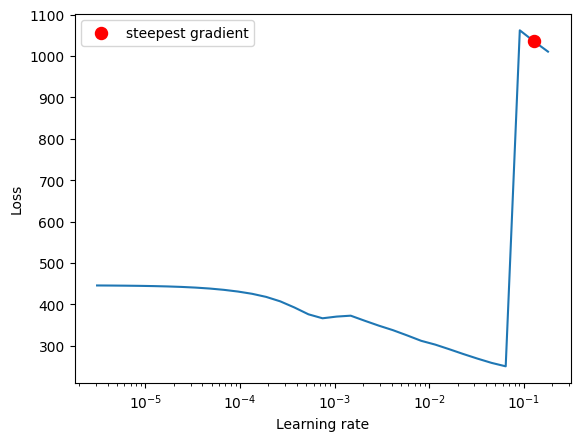

Plot saved to: logs/Regression/boston/CNN/DistanceMatrix_Model1/lr_finder_plot.png
Suggested learning rate: 0.12775649214671153


In [135]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [136]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=4e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 6.02 seconds
Best model found at epoch 13/100
Best Train Loss: 69.5234, Best Val Loss: 36.3069
Best Train MSE: 69.7531, Best Val MSE: 40.2881
Best Train RMSE: 8.3518, Best Val RMSE: 6.3473
Best model saved to models/Regression/boston/CNN/DistanceMatrix_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.45E-04


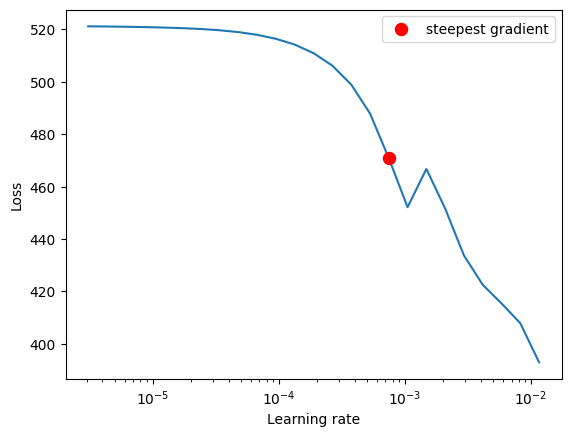

Plot saved to: logs/Regression/boston/CNN/DistanceMatrix_Model2/lr_finder_plot.png
Suggested learning rate: 0.0007453159674382293


In [137]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [138]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-4, max_lr=2e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 7.28 seconds
Best model found at epoch 8/100
Best Train Loss: 80.2594, Best Val Loss: 37.6978
Best Train MSE: 79.2500, Best Val MSE: 41.3000
Best Train RMSE: 8.9022, Best Val RMSE: 6.4265
Best model saved to models/Regression/boston/CNN/DistanceMatrix_Model2/best_model.pth


In [139]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small


Traceback (most recent call last):
  File "/tmp/ipykernel_9874/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10

In [140]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-3, max_lr=1e-1)  # Train and evaluate Model3

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small
Model DistanceMatrix_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_9874/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10

In [141]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 63.13892834003155, 'train_mse': 63.413177490234375, 'train_mae': 5.265960216522217, 'train_rmse': 7.9632391330559935, 'train_r2': 0.24628645181655884, 'val_loss': 36.306944847106934, 'val_mse': 40.28812789916992, 'val_mae': 4.708588123321533, 'val_rmse': 6.347292958353973, 'val_r2': 0.3345852494239807, 'test_loss': 94.77180099487305, 'test_mse': 96.21843719482422, 'test_mae': 7.084708213806152, 'test_rmse': 9.809099713777213, 'test_r2': 0.09366655349731445, 'min_lr': 1e-05, 'max_lr': 0.04, 'total_time': 6.024921894073486, 'average_epoch_time': 0.06024570226669312}
Model 2 Metrics: {'train_loss': 63.222214038555435, 'train_mse': 63.36420822143555, 'train_mae': 5.612869739532471, 'train_rmse': 7.960163831318772, 'train_r2': 0.24686849117279053, 'val_loss': 37.697818756103516, 'val_mse': 41.29996109008789, 'val_mae': 5.006657600402832, 'val_rmse': 6.426504577924759, 'val_r2': 0.31787335872650146, 'test_loss': 94.66059494018555, 'test_mse': 97.69610595703125

In [142]:
#Select the model and the parameters
problem_type = "regression"
image_model = DistanceMatrix(problem= problem_type, zoom=2)
name = f"DistanceMatrix_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [143]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_DistanceMatrix_zoom2/train/regression.csv
./HyNNImages/Regression/boston/images_boston_DistanceMatrix_zoom2/val/regression.csv
./HyNNImages/Regression/boston/images_boston_DistanceMatrix_zoom2/test/regression.csv
Images shape:  (3, 26, 26)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.14E-03


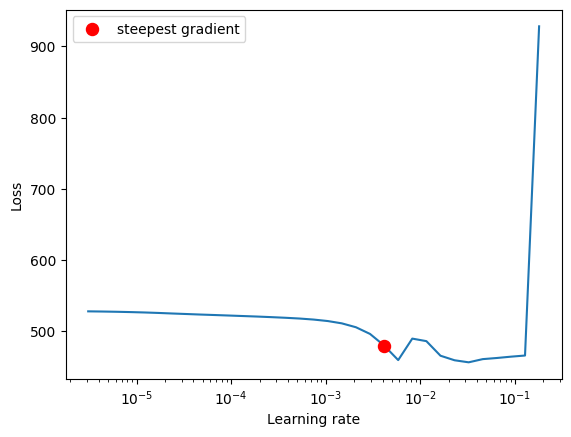

Plot saved to: logs/Regression/boston/CNN/DistanceMatrix_zoom2_Model1/lr_finder_plot.png
Suggested learning rate: 0.00414019957645922


In [144]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [145]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=5e-3, max_lr=2e-1)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.27 seconds
Best model found at epoch 25/100
Best Train Loss: 31.0000, Best Val Loss: 26.6211
Best Train MSE: 30.9937, Best Val MSE: 26.6226
Best Train RMSE: 5.5672, Best Val RMSE: 5.1597
Best model saved to models/Regression/boston/CNN/DistanceMatrix_zoom2_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.66E-04


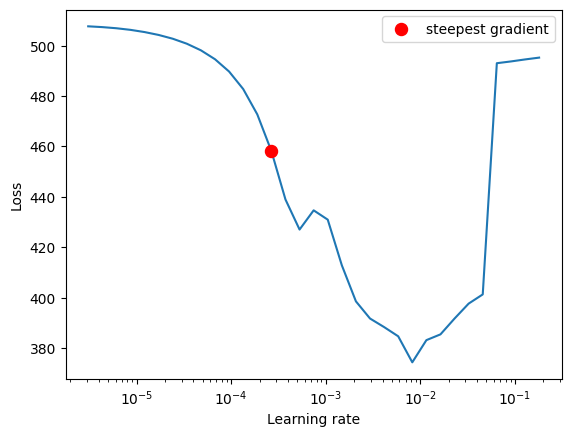

Plot saved to: logs/Regression/boston/CNN/DistanceMatrix_zoom2_Model2/lr_finder_plot.png
Suggested learning rate: 0.00026639858572587714


In [146]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [147]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=5e-5, max_lr=1e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 4.25 seconds
Best model found at epoch 92/100
Best Train Loss: 43.5066, Best Val Loss: 30.8212
Best Train MSE: 43.3598, Best Val MSE: 34.5613
Best Train RMSE: 6.5848, Best Val RMSE: 5.8789
Best model saved to models/Regression/boston/CNN/DistanceMatrix_zoom2_Model2/best_model.pth


Successfully created and tested Model3


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.09E-03


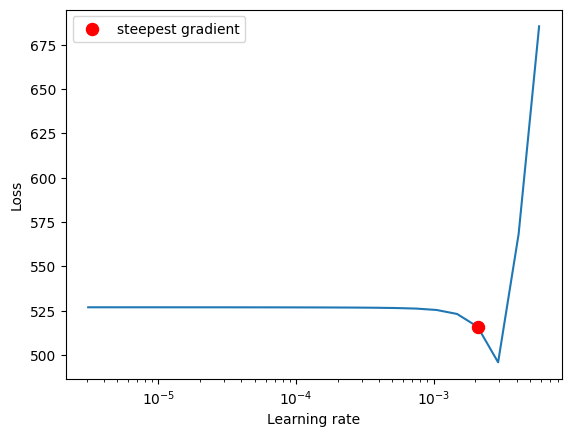

Plot saved to: logs/Regression/boston/CNN/DistanceMatrix_zoom2_Model3/lr_finder_plot.png
Suggested learning rate: 0.002085205857248754


In [148]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [149]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-3, max_lr=3e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 11.42 seconds
Best model found at epoch 86/100
Best Train Loss: 30.7893, Best Val Loss: 23.2505
Best Train MSE: 31.3345, Best Val MSE: 25.2404
Best Train RMSE: 5.5977, Best Val RMSE: 5.0240
Best model saved to models/Regression/boston/CNN/DistanceMatrix_zoom2_Model3/best_model.pth


In [150]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 27.24274180485652, 'train_mse': 27.121219635009766, 'train_mae': 3.7978415489196777, 'train_rmse': 5.207803724701015, 'train_r2': 0.6776437759399414, 'val_loss': 26.621124267578125, 'val_mse': 26.62264060974121, 'val_mae': 3.7437775135040283, 'val_rmse': 5.159713229409287, 'val_r2': 0.5602898597717285, 'test_loss': 27.730865478515625, 'test_mse': 29.709577560424805, 'test_mae': 4.349548816680908, 'test_rmse': 5.450649278794665, 'test_r2': 0.7201493978500366, 'min_lr': 0.005, 'max_lr': 0.2, 'total_time': 4.27107310295105, 'average_epoch_time': 0.04270815134048462}
Model 2 Metrics: {'train_loss': 43.10870038546049, 'train_mse': 43.834983825683594, 'train_mae': 4.245290756225586, 'train_rmse': 6.6207993343465406, 'train_r2': 0.47898805141448975, 'val_loss': 30.821176528930664, 'val_mse': 34.561302185058594, 'val_mae': 4.4583868980407715, 'val_rmse': 5.8788861347247225, 'val_r2': 0.4291718006134033, 'test_loss': 74.45158767700195, 'test_mse': 79.312004089355

In [151]:
#Select the model and the parameters
problem_type = "regression"
image_model = DistanceMatrix(problem= problem_type, zoom=4)
name = f"DistanceMatrix_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [152]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_DistanceMatrix_zoom4/train/regression.csv
./HyNNImages/Regression/boston/images_boston_DistanceMatrix_zoom4/val/regression.csv
./HyNNImages/Regression/boston/images_boston_DistanceMatrix_zoom4/test/regression.csv
Images shape:  (3, 52, 52)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.16E-02


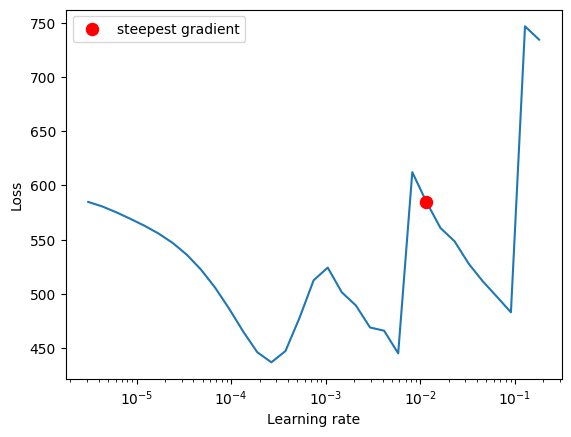

Plot saved to: logs/Regression/boston/CNN/DistanceMatrix_zoom4_Model1/lr_finder_plot.png
Suggested learning rate: 0.011583232862547112


In [153]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [154]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=2e-4, max_lr=2e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.22 seconds
Best model found at epoch 32/100
Best Train Loss: 26.5930, Best Val Loss: 22.7149
Best Train MSE: 27.1327, Best Val MSE: 23.4336
Best Train RMSE: 5.2089, Best Val RMSE: 4.8408
Best model saved to models/Regression/boston/CNN/DistanceMatrix_zoom4_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.34E-04


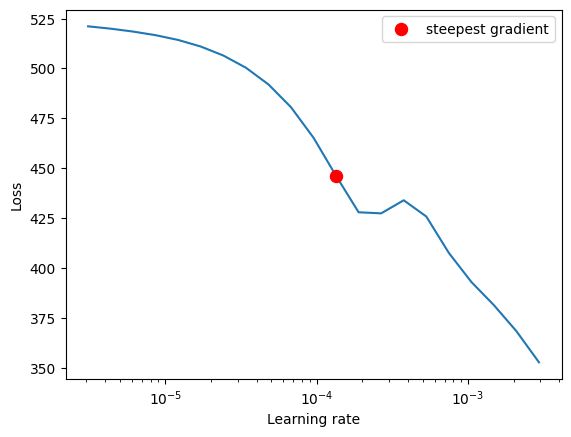

Plot saved to: logs/Regression/boston/CNN/DistanceMatrix_zoom4_Model2/lr_finder_plot.png
Suggested learning rate: 0.00013417128354799112


In [155]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [156]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=2e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 4.77 seconds
Best model found at epoch 87/100
Best Train Loss: 14.5398, Best Val Loss: 21.2250
Best Train MSE: 14.6965, Best Val MSE: 22.6074
Best Train RMSE: 3.8336, Best Val RMSE: 4.7547
Best model saved to models/Regression/boston/CNN/DistanceMatrix_zoom4_Model2/best_model.pth


Successfully created and tested Model3


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.83E-03


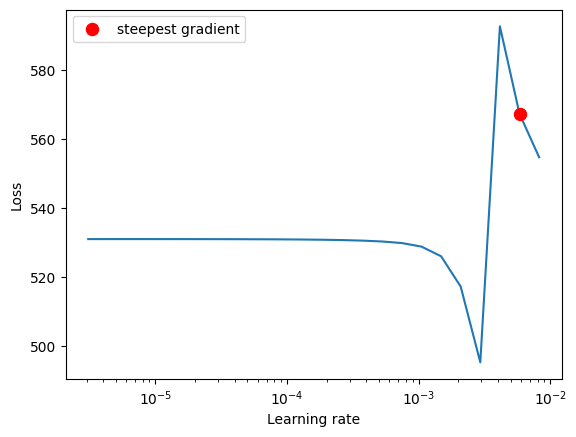

Plot saved to: logs/Regression/boston/CNN/DistanceMatrix_zoom4_Model3/lr_finder_plot.png
Suggested learning rate: 0.005833879397552116


In [157]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [158]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=8e-4, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 10.34 seconds
Best model found at epoch 91/100
Best Train Loss: 31.5358, Best Val Loss: 26.7731
Best Train MSE: 31.8386, Best Val MSE: 28.6945
Best Train RMSE: 5.6426, Best Val RMSE: 5.3567
Best model saved to models/Regression/boston/CNN/DistanceMatrix_zoom4_Model3/best_model.pth


In [159]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 24.725030678969162, 'train_mse': 24.563514709472656, 'train_mae': 3.493786096572876, 'train_rmse': 4.956159269986453, 'train_r2': 0.7080440521240234, 'val_loss': 22.714884757995605, 'val_mse': 23.43358612060547, 'val_mae': 3.399771213531494, 'val_rmse': 4.840824942156602, 'val_r2': 0.6129615306854248, 'test_loss': 25.17477321624756, 'test_mse': 26.38698387145996, 'test_mae': 3.995887279510498, 'test_rmse': 5.136826245013546, 'test_r2': 0.7514467239379883, 'min_lr': 0.0002, 'max_lr': 0.02, 'total_time': 4.216467380523682, 'average_epoch_time': 0.04216209173202515}
Model 2 Metrics: {'train_loss': 14.633426739619328, 'train_mse': 14.367359161376953, 'train_mae': 2.6750922203063965, 'train_rmse': 3.790429944132585, 'train_r2': 0.8292330503463745, 'val_loss': 21.225032806396484, 'val_mse': 22.60739517211914, 'val_mae': 3.4301700592041016, 'val_rmse': 4.7547234590582805, 'val_r2': 0.6266072988510132, 'test_loss': 26.87185573577881, 'test_mse': 27.4441070556640

### EXPERIMENT 6: COMBINATION

In [160]:
#Select the model and the parameters
problem_type = "regression"
image_model = Combination(problem= problem_type)
name = f"Combination"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [161]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_Combination/train/regression.csv
./HyNNImages/Regression/boston/images_boston_Combination/val/regression.csv
./HyNNImages/Regression/boston/images_boston_Combination/test/regression.csv
Images shape:  (3, 13, 13)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.48E-03


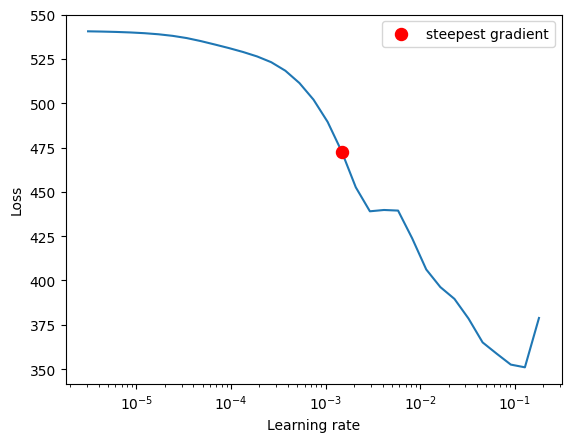

Plot saved to: logs/Regression/boston/CNN/Combination_Model1/lr_finder_plot.png
Suggested learning rate: 0.0014798331982375287


In [162]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [163]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-4, max_lr=3e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 3.98 seconds
Best model found at epoch 10/100
Best Train Loss: 23.9927, Best Val Loss: 18.6811
Best Train MSE: 24.3095, Best Val MSE: 18.9229
Best Train RMSE: 4.9305, Best Val RMSE: 4.3500
Best model saved to models/Regression/boston/CNN/Combination_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.45E-04


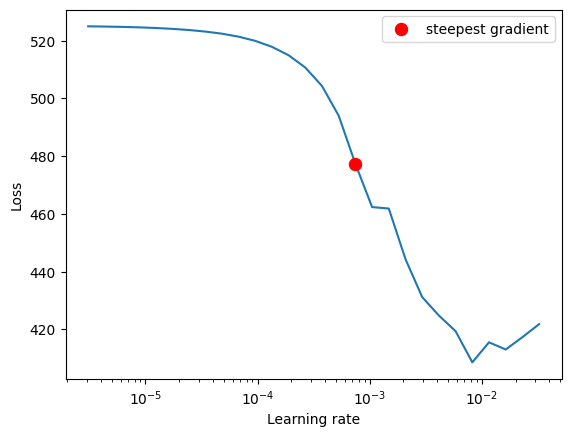

Plot saved to: logs/Regression/boston/CNN/Combination_Model2/lr_finder_plot.png
Suggested learning rate: 0.0007453159674382293


In [164]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [165]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-4, max_lr=2e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 4.56 seconds
Best model found at epoch 9/100
Best Train Loss: 28.9216, Best Val Loss: 19.3110
Best Train MSE: 29.3343, Best Val MSE: 20.5851
Best Train RMSE: 5.4161, Best Val RMSE: 4.5371
Best model saved to models/Regression/boston/CNN/Combination_Model2/best_model.pth


In [166]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small


Traceback (most recent call last):
  File "/tmp/ipykernel_9874/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10

In [167]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-3, max_lr=1e-1)  # Train and evaluate Model3

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small
Model Combination_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_9874/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10

In [168]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 21.76889082101675, 'train_mse': 21.90007209777832, 'train_mae': 3.2213449478149414, 'train_rmse': 4.679751285888847, 'train_r2': 0.7397010922431946, 'val_loss': 18.681138038635254, 'val_mse': 18.92293357849121, 'val_mae': 3.3561267852783203, 'val_rmse': 4.350049836322707, 'val_r2': 0.6874613165855408, 'test_loss': 46.890066146850586, 'test_mse': 50.07725524902344, 'test_mae': 5.307466983795166, 'test_rmse': 7.076528474402081, 'test_r2': 0.5282952785491943, 'min_lr': 0.0001, 'max_lr': 0.03, 'total_time': 3.9794392585754395, 'average_epoch_time': 0.03979100465774536}
Model 2 Metrics: {'train_loss': 23.276317816514236, 'train_mse': 23.829967498779297, 'train_mae': 3.0942511558532715, 'train_rmse': 4.881594770029492, 'train_r2': 0.7167628407478333, 'val_loss': 19.311014652252197, 'val_mse': 20.58509063720703, 'val_mae': 3.6127636432647705, 'val_rmse': 4.5370795273178794, 'val_r2': 0.660008430480957, 'test_loss': 63.91568565368652, 'test_mse': 69.000152587890

In [169]:
#Select the model and the parameters
problem_type = "regression"
image_model = Combination(problem= problem_type, zoom=2)
name = f"Combination_zoom2"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [170]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_Combination_zoom2/train/regression.csv
./HyNNImages/Regression/boston/images_boston_Combination_zoom2/val/regression.csv
./HyNNImages/Regression/boston/images_boston_Combination_zoom2/test/regression.csv
Images shape:  (3, 26, 26)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.76E-05


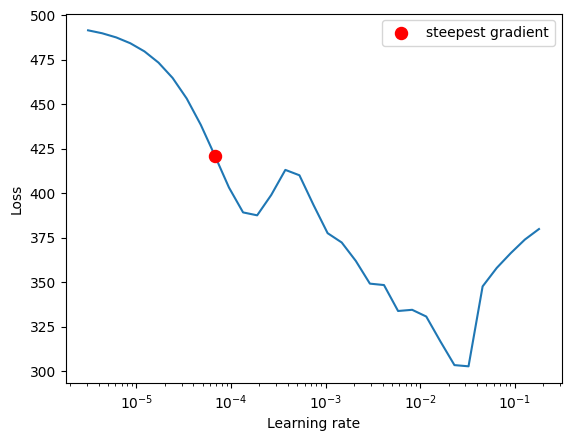

Plot saved to: logs/Regression/boston/CNN/Combination_zoom2_Model1/lr_finder_plot.png
Suggested learning rate: 6.757518355386218e-05


In [171]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [172]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=4e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 3.71 seconds
Best model found at epoch 10/100
Best Train Loss: 17.3106, Best Val Loss: 20.0254
Best Train MSE: 17.5749, Best Val MSE: 20.7517
Best Train RMSE: 4.1922, Best Val RMSE: 4.5554
Best model saved to models/Regression/boston/CNN/Combination_zoom2_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.89E-04


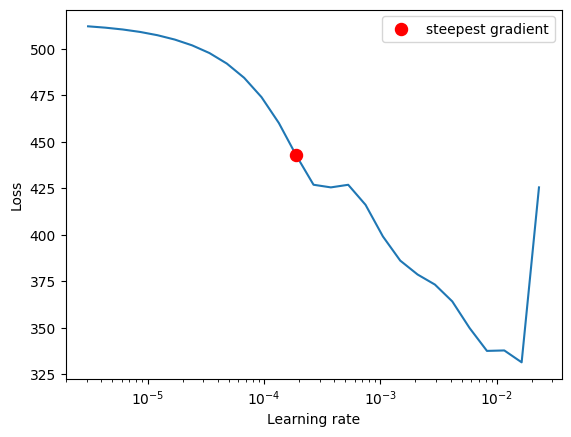

Plot saved to: logs/Regression/boston/CNN/Combination_zoom2_Model2/lr_finder_plot.png
Suggested learning rate: 0.00018905829836907587


In [173]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [174]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=5e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 4.12 seconds
Best model found at epoch 13/100
Best Train Loss: 17.1488, Best Val Loss: 18.2297
Best Train MSE: 17.1850, Best Val MSE: 18.2277
Best Train RMSE: 4.1455, Best Val RMSE: 4.2694
Best model saved to models/Regression/boston/CNN/Combination_zoom2_Model2/best_model.pth


Successfully created and tested Model3


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.22E-03


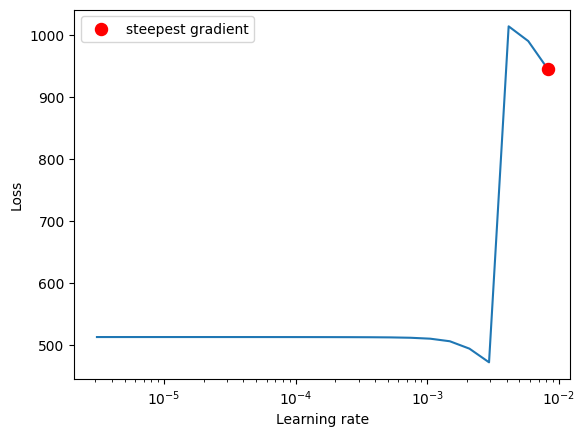

Plot saved to: logs/Regression/boston/CNN/Combination_zoom2_Model3/lr_finder_plot.png
Suggested learning rate: 0.008220412614574906


In [175]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [176]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-3, max_lr=3e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 9.86 seconds
Best model found at epoch 18/100
Best Train Loss: 35.0202, Best Val Loss: 21.5843
Best Train MSE: 35.1866, Best Val MSE: 21.8806
Best Train RMSE: 5.9318, Best Val RMSE: 4.6777
Best model saved to models/Regression/boston/CNN/Combination_zoom2_Model3/best_model.pth


In [177]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 10.829265044285702, 'train_mse': 10.795486450195312, 'train_mae': 2.329862117767334, 'train_rmse': 3.2856485585338113, 'train_r2': 0.8716874718666077, 'val_loss': 20.025390625, 'val_mse': 20.751699447631836, 'val_mae': 3.3508551120758057, 'val_rmse': 4.555403324364576, 'val_r2': 0.6572566628456116, 'test_loss': 21.753648281097412, 'test_mse': 24.188501358032227, 'test_mae': 3.298337459564209, 'test_rmse': 4.918180695951729, 'test_r2': 0.7721554040908813, 'min_lr': 1e-05, 'max_lr': 0.04, 'total_time': 3.7144381999969482, 'average_epoch_time': 0.03714169502258301}
Model 2 Metrics: {'train_loss': 11.191038095034086, 'train_mse': 11.209697723388672, 'train_mae': 2.3394405841827393, 'train_rmse': 3.348088667193369, 'train_r2': 0.8667643070220947, 'val_loss': 18.229745864868164, 'val_mse': 18.22772789001465, 'val_mae': 3.165513277053833, 'val_rmse': 4.269394323556288, 'val_r2': 0.6989436149597168, 'test_loss': 20.99019145965576, 'test_mse': 23.301719665527344,

In [178]:
#Select the model and the parameters
problem_type = "regression"
image_model = Combination(problem= problem_type, zoom=4)
name = f"Combination_zoom4"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [179]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_Combination_zoom4/train/regression.csv
./HyNNImages/Regression/boston/images_boston_Combination_zoom4/val/regression.csv
./HyNNImages/Regression/boston/images_boston_Combination_zoom4/test/regression.csv
Images shape:  (3, 52, 52)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.52E-05


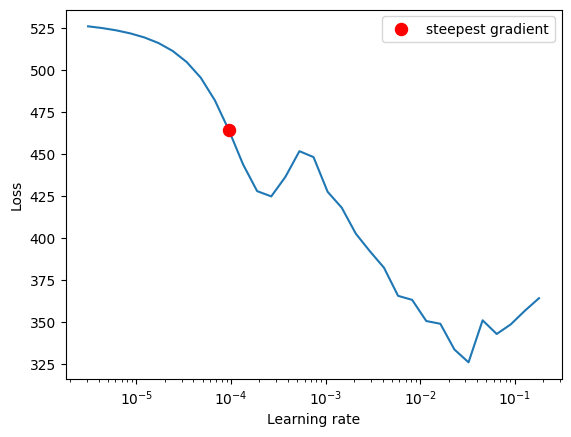

Plot saved to: logs/Regression/boston/CNN/Combination_zoom4_Model1/lr_finder_plot.png
Suggested learning rate: 9.521895354084078e-05


In [180]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [181]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-4, max_lr=1e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 3.63 seconds
Best model found at epoch 9/100
Best Train Loss: 16.5544, Best Val Loss: 19.0048
Best Train MSE: 16.8420, Best Val MSE: 18.9230
Best Train RMSE: 4.1039, Best Val RMSE: 4.3501
Best model saved to models/Regression/boston/CNN/Combination_zoom4_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.89E-04


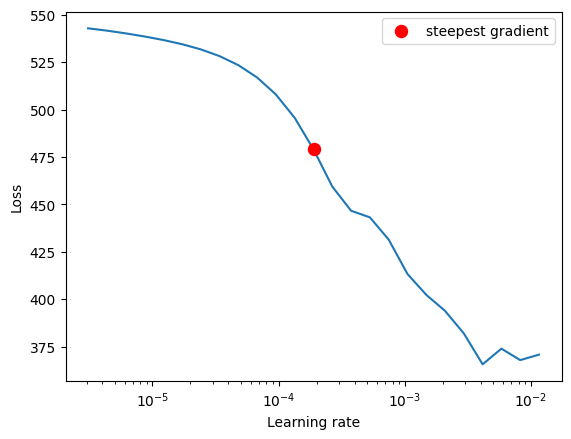

Plot saved to: logs/Regression/boston/CNN/Combination_zoom4_Model2/lr_finder_plot.png
Suggested learning rate: 0.00018905829836907587


In [182]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [183]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=3e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.30 seconds
Best model found at epoch 8/100
Best Train Loss: 25.7944, Best Val Loss: 19.6026
Best Train MSE: 25.9909, Best Val MSE: 19.6645
Best Train RMSE: 5.0981, Best Val RMSE: 4.4345
Best model saved to models/Regression/boston/CNN/Combination_zoom4_Model2/best_model.pth


Successfully created and tested Model3


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.83E-03


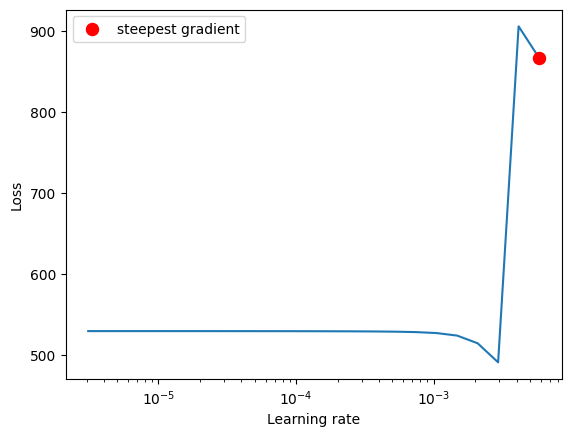

Plot saved to: logs/Regression/boston/CNN/Combination_zoom4_Model3/lr_finder_plot.png
Suggested learning rate: 0.005833879397552116


In [184]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [185]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=5e-4, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 10.29 seconds
Best model found at epoch 66/100
Best Train Loss: 16.7461, Best Val Loss: 24.1201
Best Train MSE: 16.7020, Best Val MSE: 24.4246
Best Train RMSE: 4.0868, Best Val RMSE: 4.9421
Best model saved to models/Regression/boston/CNN/Combination_zoom4_Model3/best_model.pth


In [186]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 17.522613598750187, 'train_mse': 17.604232788085938, 'train_mae': 2.9062464237213135, 'train_rmse': 4.195739837988759, 'train_r2': 0.7907603979110718, 'val_loss': 19.00484848022461, 'val_mse': 18.922977447509766, 'val_mae': 2.99251127243042, 'val_rmse': 4.350054878677942, 'val_r2': 0.6874605417251587, 'test_loss': 39.500325202941895, 'test_mse': 41.63203048706055, 'test_mae': 4.66018533706665, 'test_rmse': 6.452288778957476, 'test_r2': 0.6078454256057739, 'min_lr': 0.0001, 'max_lr': 0.01, 'total_time': 3.6278023719787598, 'average_epoch_time': 0.0362752103805542}
Model 2 Metrics: {'train_loss': 16.070415019989014, 'train_mse': 16.02112579345703, 'train_mae': 2.5181493759155273, 'train_rmse': 4.002639853079094, 'train_r2': 0.8095767498016357, 'val_loss': 19.60256576538086, 'val_mse': 19.664478302001953, 'val_mae': 3.4090638160705566, 'val_rmse': 4.43446482701148, 'val_r2': 0.675213634967804, 'test_loss': 36.75678634643555, 'test_mse': 41.00117111206055, '

### EXPERIMENT 7: SUPERTML

In [187]:
#Select the model and the parameters
problem_type = "regression"
image_model = SuperTML(problem= problem_type, random_seed=SEED)
name = f"SuperTML-EF"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [188]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_SuperTML-EF/train/regression.csv
./HyNNImages/Regression/boston/images_boston_SuperTML-EF/val/regression.csv
./HyNNImages/Regression/boston/images_boston_SuperTML-EF/test/regression.csv
Images shape:  (3, 224, 224)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.89E-04


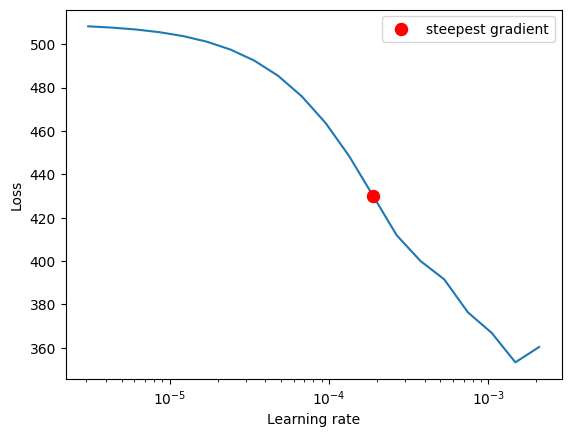

Plot saved to: logs/Regression/boston/CNN/SuperTML-EF_Model1/lr_finder_plot.png
Suggested learning rate: 0.00018905829836907587


In [189]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [190]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=3e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 12.84 seconds
Best model found at epoch 44/100
Best Train Loss: 2.3377, Best Val Loss: 19.8010
Best Train MSE: 2.3378, Best Val MSE: 21.0662
Best Train RMSE: 1.5290, Best Val RMSE: 4.5898
Best model saved to models/Regression/boston/CNN/SuperTML-EF_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.24E-02


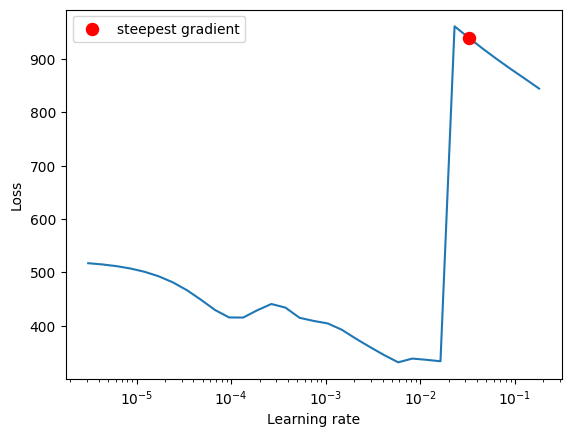

Plot saved to: logs/Regression/boston/CNN/SuperTML-EF_Model2/lr_finder_plot.png
Suggested learning rate: 0.03240696035787169


In [191]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [192]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=2e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 26.05 seconds
Best model found at epoch 12/100
Best Train Loss: 10.0709, Best Val Loss: 21.2906
Best Train MSE: 10.1297, Best Val MSE: 21.6171
Best Train RMSE: 3.1827, Best Val RMSE: 4.6494
Best model saved to models/Regression/boston/CNN/SuperTML-EF_Model2/best_model.pth


Successfully created and tested Model3


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.05E-03


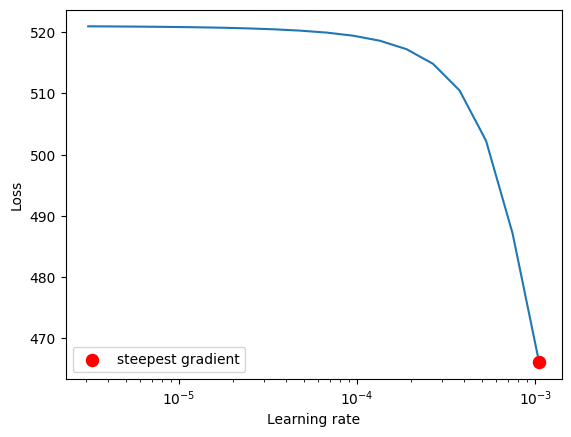

Plot saved to: logs/Regression/boston/CNN/SuperTML-EF_Model3/lr_finder_plot.png
Suggested learning rate: 0.0010502110796366674


In [193]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [194]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-4, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 40.66 seconds
Best model found at epoch 83/100
Best Train Loss: 18.1476, Best Val Loss: 15.3806
Best Train MSE: 18.2117, Best Val MSE: 16.4499
Best Train RMSE: 4.2675, Best Val RMSE: 4.0558
Best model saved to models/Regression/boston/CNN/SuperTML-EF_Model3/best_model.pth


In [195]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 1.4792081759526179, 'train_mse': 1.481111764907837, 'train_mae': 0.9504231214523315, 'train_rmse': 1.217009352843205, 'train_r2': 0.9823958873748779, 'val_loss': 19.800955772399902, 'val_mse': 21.066207885742188, 'val_mae': 3.810472011566162, 'val_rmse': 4.589793882707827, 'val_r2': 0.6520621180534363, 'test_loss': 18.668216705322266, 'test_mse': 18.68031120300293, 'test_mae': 3.329897165298462, 'test_rmse': 4.322072558738797, 'test_r2': 0.8240400552749634, 'min_lr': 1e-05, 'max_lr': 0.03, 'total_time': 12.840204000473022, 'average_epoch_time': 0.128396897315979}
Model 2 Metrics: {'train_loss': 8.110155985905575, 'train_mse': 8.205777168273926, 'train_mae': 2.1451730728149414, 'train_rmse': 2.8645727723822842, 'train_r2': 0.9024681448936462, 'val_loss': 21.290578842163086, 'val_mse': 21.617137908935547, 'val_mae': 4.012399196624756, 'val_rmse': 4.649423395318558, 'val_r2': 0.6429627537727356, 'test_loss': 17.417821407318115, 'test_mse': 18.09140777587890

In [196]:
#Select the model and the parameters
problem_type = "regression"
image_model = SuperTML(problem= problem_type, feature_importance=True, font_size=30, random_seed=SEED)
name = f"SuperTML-VF_FS30"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [197]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_SuperTML-VF_FS30/train/regression.csv
./HyNNImages/Regression/boston/images_boston_SuperTML-VF_FS30/val/regression.csv
./HyNNImages/Regression/boston/images_boston_SuperTML-VF_FS30/test/regression.csv
Images shape:  (3, 224, 224)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.80E-05


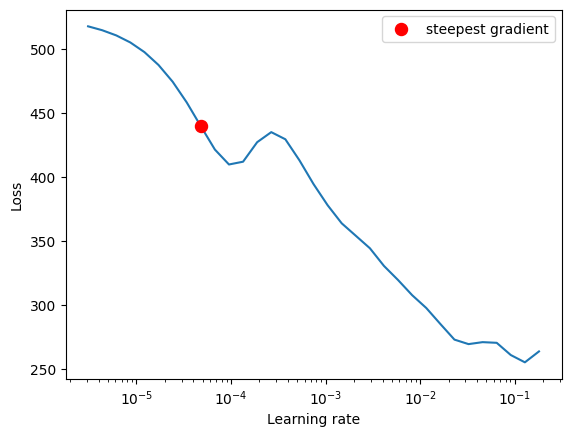

Plot saved to: logs/Regression/boston/CNN/SuperTML-VF_FS30_Model1/lr_finder_plot.png
Suggested learning rate: 4.7956895791546077e-05


In [198]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [199]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=5e-6, max_lr=8e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 12.31 seconds
Best model found at epoch 13/100
Best Train Loss: 21.1600, Best Val Loss: 23.7067
Best Train MSE: 21.2347, Best Val MSE: 24.5833
Best Train RMSE: 4.6081, Best Val RMSE: 4.9582
Best model saved to models/Regression/boston/CNN/SuperTML-VF_FS30_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.42E-05


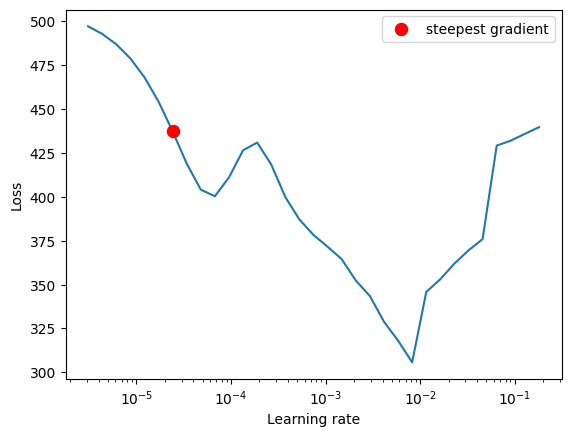

Plot saved to: logs/Regression/boston/CNN/SuperTML-VF_FS30_Model2/lr_finder_plot.png
Suggested learning rate: 2.4153425010859467e-05


In [200]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [201]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=5e-6, max_lr=5e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 25.92 seconds
Best model found at epoch 44/100
Best Train Loss: 1.3425, Best Val Loss: 21.3328
Best Train MSE: 1.3077, Best Val MSE: 23.2764
Best Train RMSE: 1.1435, Best Val RMSE: 4.8246
Best model saved to models/Regression/boston/CNN/SuperTML-VF_FS30_Model2/best_model.pth


Successfully created and tested Model3


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.48E-03


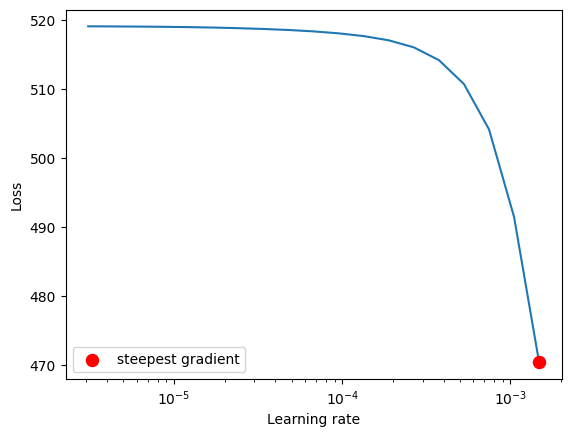

Plot saved to: logs/Regression/boston/CNN/SuperTML-VF_FS30_Model3/lr_finder_plot.png
Suggested learning rate: 0.0014798331982375287


In [202]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

In [203]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-4, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 40.86 seconds
Best model found at epoch 35/100
Best Train Loss: 34.4124, Best Val Loss: 22.5387
Best Train MSE: 34.5343, Best Val MSE: 23.2590
Best Train RMSE: 5.8766, Best Val RMSE: 4.8228
Best model saved to models/Regression/boston/CNN/SuperTML-VF_FS30_Model3/best_model.pth


In [204]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 14.280476606809176, 'train_mse': 13.941147804260254, 'train_mae': 2.672252655029297, 'train_rmse': 3.733784648886469, 'train_r2': 0.8342989087104797, 'val_loss': 23.70673179626465, 'val_mse': 24.58332061767578, 'val_mae': 3.9326884746551514, 'val_rmse': 4.958156977917882, 'val_r2': 0.5939720869064331, 'test_loss': 195.89165496826172, 'test_mse': 193.83840942382812, 'test_mae': 10.79661750793457, 'test_rmse': 13.922586305131246, 'test_r2': -0.8258687257766724, 'min_lr': 5e-06, 'max_lr': 0.08, 'total_time': 12.309330940246582, 'average_epoch_time': 0.12308889627456665}
Model 2 Metrics: {'train_loss': 0.7912689309853774, 'train_mse': 0.7968411445617676, 'train_mae': 0.6985481381416321, 'train_rmse': 0.8926595905280845, 'train_r2': 0.99052894115448, 'val_loss': 21.332764148712158, 'val_mse': 23.276445388793945, 'val_mae': 3.431079864501953, 'val_rmse': 4.824566860226309, 'val_r2': 0.6155569553375244, 'test_loss': 161.78309631347656, 'test_mse': 160.105026245

In [205]:
#Select the model and the parameters
problem_type = "regression"
image_model = SuperTML(problem= problem_type, feature_importance=True, font_size=70, random_seed=SEED)
name = f"SuperTML-VF_FS70"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [206]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_SuperTML-VF_FS70/train/regression.csv
./HyNNImages/Regression/boston/images_boston_SuperTML-VF_FS70/val/regression.csv
./HyNNImages/Regression/boston/images_boston_SuperTML-VF_FS70/test/regression.csv
Images shape:  (3, 224, 224)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/144 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.63E-06


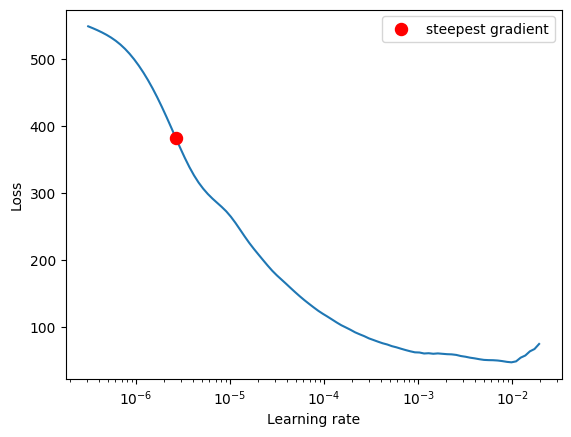

Plot saved to: logs/Regression/boston/CNN/SuperTML-VF_FS70_Model1/lr_finder_plot.png
Suggested learning rate: 2.6277280655179453e-06


In [207]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=(num_epochs*3))

In [208]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-6, max_lr=1e-1)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 12.20 seconds
Best model found at epoch 10/100
Best Train Loss: 29.6669, Best Val Loss: 22.4721
Best Train MSE: 29.1410, Best Val MSE: 23.0431
Best Train RMSE: 5.3982, Best Val RMSE: 4.8003
Best model saved to models/Regression/boston/CNN/SuperTML-VF_FS70_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/144 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.47E-06


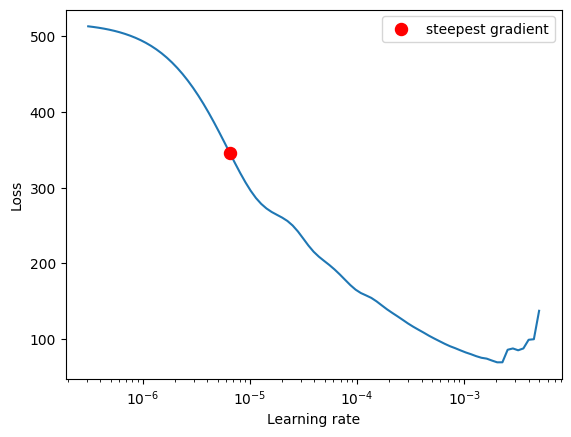

Plot saved to: logs/Regression/boston/CNN/SuperTML-VF_FS70_Model2/lr_finder_plot.png
Suggested learning rate: 6.4742402464589075e-06


In [209]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=(num_epochs*3))

In [210]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=3e-4, max_lr=1e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 25.92 seconds
Best model found at epoch 42/100
Best Train Loss: 9.3154, Best Val Loss: 19.5124
Best Train MSE: 9.4446, Best Val MSE: 21.2435
Best Train RMSE: 3.0732, Best Val RMSE: 4.6091
Best model saved to models/Regression/boston/CNN/SuperTML-VF_FS70_Model2/best_model.pth


Successfully created and tested Model3


  0%|          | 0/144 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.10E-02


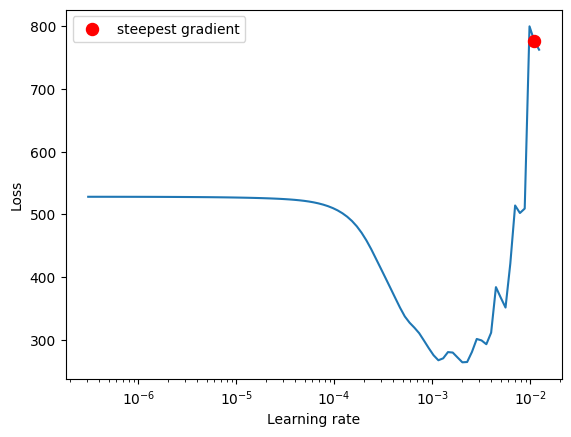

Plot saved to: logs/Regression/boston/CNN/SuperTML-VF_FS70_Model3/lr_finder_plot.png
Suggested learning rate: 0.0110143289280821


In [211]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=(num_epochs*3))

In [212]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=1e-4, max_lr=2e-3)  # Train and evaluate Model3

Successfully created and tested Model3

Training completed in 40.87 seconds
Best model found at epoch 39/100
Best Train Loss: 34.0624, Best Val Loss: 22.9131
Best Train MSE: 34.3066, Best Val MSE: 23.4088
Best Train RMSE: 5.8572, Best Val RMSE: 4.8383
Best model saved to models/Regression/boston/CNN/SuperTML-VF_FS70_Model3/best_model.pth


In [213]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 20.65985819009634, 'train_mse': 20.70290756225586, 'train_mae': 3.360111713409424, 'train_rmse': 4.550044786840659, 'train_r2': 0.7539303302764893, 'val_loss': 22.4721097946167, 'val_mse': 23.0430850982666, 'val_mae': 3.942216396331787, 'val_rmse': 4.80032135364567, 'val_r2': 0.6194112300872803, 'test_loss': 218.93157958984375, 'test_mse': 220.8466339111328, 'test_mae': 12.047527313232422, 'test_rmse': 14.860909592320816, 'test_r2': -1.0802738666534424, 'min_lr': 1e-06, 'max_lr': 0.1, 'total_time': 12.198533296585083, 'average_epoch_time': 0.12198059320449829}
Model 2 Metrics: {'train_loss': 4.653612503638635, 'train_mse': 4.625348091125488, 'train_mae': 1.548492431640625, 'train_rmse': 2.1506622447807766, 'train_r2': 0.9450242519378662, 'val_loss': 19.512393951416016, 'val_mse': 21.243532180786133, 'val_mae': 3.5724518299102783, 'val_rmse': 4.609070641765662, 'val_r2': 0.6491333246231079, 'test_loss': 141.47894287109375, 'test_mse': 140.2260284423828, '

### EXPERIMENT 8: FeatureWrap

In [214]:
#Select the model and the parameters
problem_type = "regression"
image_model = FeatureWrap(problem = problem_type, bins=10)
name = f"FeatureWrap"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [215]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_FeatureWrap/train/regression.csv
./HyNNImages/Regression/boston/images_boston_FeatureWrap/val/regression.csv
./HyNNImages/Regression/boston/images_boston_FeatureWrap/test/regression.csv
Images shape:  (3, 8, 8)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.14E-03


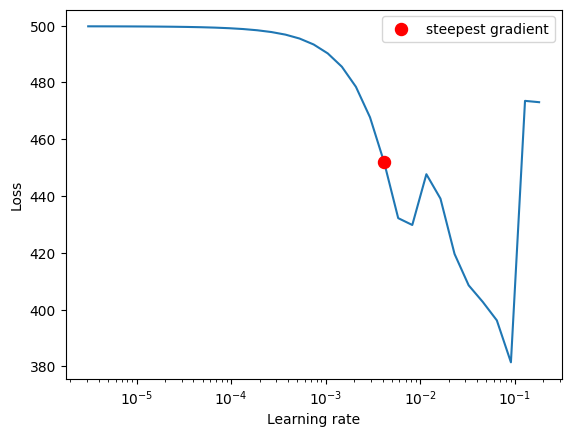

Plot saved to: logs/Regression/boston/CNN/FeatureWrap_Model1/lr_finder_plot.png
Suggested learning rate: 0.00414019957645922


In [216]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [217]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-3, max_lr=2e-1)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.25 seconds
Best model found at epoch 4/100
Best Train Loss: 85.1887, Best Val Loss: 36.4882
Best Train MSE: 85.4963, Best Val MSE: 36.1696
Best Train RMSE: 9.2464, Best Val RMSE: 6.0141
Best model saved to models/Regression/boston/CNN/FeatureWrap_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.94E-03


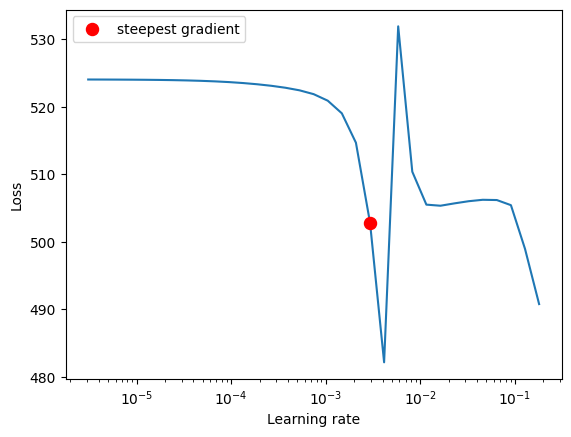

Plot saved to: logs/Regression/boston/CNN/FeatureWrap_Model2/lr_finder_plot.png
Suggested learning rate: 0.0029382253839710104


In [218]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [219]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=5e-4, max_lr=2e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 5.26 seconds
Best model found at epoch 37/100
Best Train Loss: 23.4264, Best Val Loss: 32.9093
Best Train MSE: 23.3999, Best Val MSE: 33.6857
Best Train RMSE: 4.8373, Best Val RMSE: 5.8039
Best model saved to models/Regression/boston/CNN/FeatureWrap_Model2/best_model.pth


In [220]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small


Traceback (most recent call last):
  File "/tmp/ipykernel_9874/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10

In [221]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-4, max_lr=2e-3)  # Train and evaluate Model3

Error creating or testing Model3: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small
Model FeatureWrap_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_9874/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10

In [222]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 43.50791887136606, 'train_mse': 43.6568489074707, 'train_mae': 4.684466361999512, 'train_rmse': 6.607332964780169, 'train_r2': 0.48110532760620117, 'val_loss': 36.48818778991699, 'val_mse': 36.169639587402344, 'val_mae': 5.065690040588379, 'val_rmse': 6.014120017708521, 'val_r2': 0.40260785818099976, 'test_loss': 46.31919860839844, 'test_mse': 49.73448944091797, 'test_mae': 4.82390022277832, 'test_rmse': 7.05226838973943, 'test_r2': 0.5315239429473877, 'min_lr': 0.001, 'max_lr': 0.2, 'total_time': 4.249814033508301, 'average_epoch_time': 0.04249620914459228}
Model 2 Metrics: {'train_loss': 17.465703817514274, 'train_mse': 17.300657272338867, 'train_mae': 2.85616397857666, 'train_rmse': 4.159405879730766, 'train_r2': 0.7943686246871948, 'val_loss': 32.90932559967041, 'val_mse': 33.68574905395508, 'val_mae': 4.6718926429748535, 'val_rmse': 5.803942543991548, 'val_r2': 0.4436327815055847, 'test_loss': 28.641870498657227, 'test_mse': 30.151079177856445, 'tes

### EXPERIMENT 9: BIE

In [223]:
#Select the model and the parameters
problem_type = "regression"
image_model = BIE(problem = problem_type)
name = f"BIE"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [224]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

./HyNNImages/Regression/boston/images_boston_BIE/train/regression.csv
./HyNNImages/Regression/boston/images_boston_BIE/val/regression.csv
./HyNNImages/Regression/boston/images_boston_BIE/test/regression.csv
Images shape:  (3, 13, 32)
Attributes:  13


Successfully created and tested Model1


  0%|          | 0/48 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.66E-04


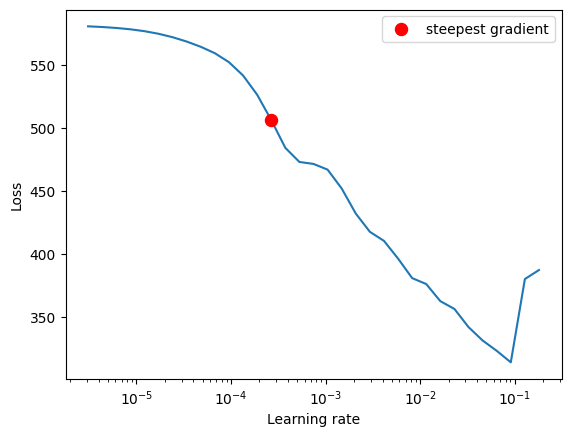

Plot saved to: logs/Regression/boston/CNN/BIE_Model1/lr_finder_plot.png
Suggested learning rate: 0.00026639858572587714


In [225]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [226]:
# Create and train Model1
model1 = try_create_model(Model1, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-5, max_lr=6e-2)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 4.42 seconds
Best model found at epoch 17/100
Best Train Loss: 15.0181, Best Val Loss: 22.1351
Best Train MSE: 14.8065, Best Val MSE: 26.5332
Best Train RMSE: 3.8479, Best Val RMSE: 5.1510
Best model saved to models/Regression/boston/CNN/BIE_Model1/best_model.pth


Successfully created and tested Model2


  0%|          | 0/48 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.66E-04


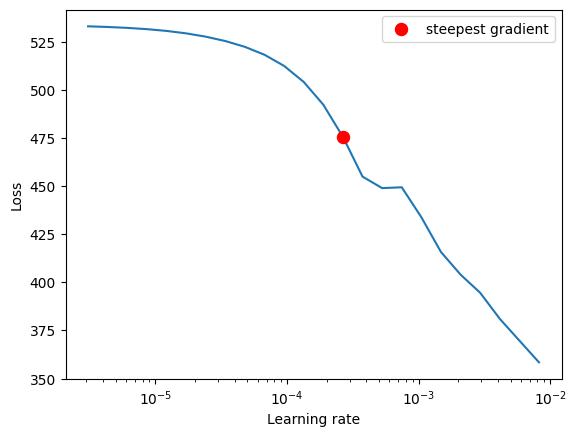

Plot saved to: logs/Regression/boston/CNN/BIE_Model2Y/lr_finder_plot.png
Suggested learning rate: 0.00026639858572587714


In [227]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2Y", train_loader, val_loader, num_iter=num_epochs)

In [228]:
# Create and train Model2
model2 = try_create_model(Model2, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-5, max_lr=2e-2)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 4.22 seconds
Best model found at epoch 23/100
Best Train Loss: 22.5754, Best Val Loss: 27.2394
Best Train MSE: 22.3369, Best Val MSE: 29.3819
Best Train RMSE: 4.7262, Best Val RMSE: 5.4205
Best model saved to models/Regression/boston/CNN/BIE_Model2/best_model.pth


In [229]:
lr = run_lr_finder(Model3, attributes, imgs_shape, dataset_name, f"{name}_Model3Y", train_loader, val_loader, num_iter=num_epochs)

Error creating or testing Model3: Given input size: (64x1x4). Calculated output size: (64x0x2). Output size is too small


Traceback (most recent call last):
  File "/tmp/ipykernel_9874/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10

In [230]:
# Create and train Model3
model3 = try_create_model(Model3, imgs_shape)  # Attempt to create Model3
model3_metrics = safe_compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model3", min_lr=2e-4, max_lr=2e-3)  # Train and evaluate Model3

Error creating or testing Model3: Given input size: (64x1x4). Calculated output size: (64x0x2). Output size is too small
Model BIE_Model3 is None


Traceback (most recent call last):
  File "/tmp/ipykernel_9874/495123367.py", line 5, in try_create_model
    model = model_class(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 67, in __init__
    self.flat_size = self._get_flat_size(imgs_shape)
  File "/tmp/ipykernel_9874/2359567951.py", line 92, in _get_flat_size
    branch_1_out = self.branch_1(dummy_input)  # branch_1
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10

In [231]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available
if model3_metrics:
    print("Model 3 Metrics:", model3_metrics)  # Print metrics for Model3 if available

Model 1 Metrics: {'train_loss': 8.027584956242489, 'train_mse': 8.022180557250977, 'train_mae': 2.1333768367767334, 'train_rmse': 2.832345416302711, 'train_r2': 0.9046503305435181, 'val_loss': 22.135091066360474, 'val_mse': 26.53324317932129, 'val_mae': 3.498328924179077, 'val_rmse': 5.151042921518058, 'val_r2': 0.5617663860321045, 'test_loss': 36.903624534606934, 'test_mse': 40.953826904296875, 'test_mae': 4.154305934906006, 'test_rmse': 6.399517708725938, 'test_r2': 0.6142337322235107, 'min_lr': 1e-05, 'max_lr': 0.06, 'total_time': 4.418241739273071, 'average_epoch_time': 0.04417990207672119}
Model 2 Metrics: {'train_loss': 17.921484213608963, 'train_mse': 17.995607376098633, 'train_mae': 3.1078059673309326, 'train_rmse': 4.242122979841418, 'train_r2': 0.7861086130142212, 'val_loss': 27.23942279815674, 'val_mse': 29.381855010986328, 'val_mae': 4.501657009124756, 'val_rmse': 5.420503206436311, 'val_r2': 0.5147175788879395, 'test_loss': 44.72244358062744, 'test_mse': 51.44805908203125,

## FINAL METRICS AND BEST MODEL

In [232]:
def find_best_model(base_path):
    best_rmse = float('inf')
    best_folder = None

    # Walk through all directories and files in the base path
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file == f'metrics.txt':
                file_path = os.path.join(root, file)
                
                # Read metrics from the file
                with open(file_path, 'r') as f:
                    metrics = f.read()
                
                # Parse the metrics into a dictionary
                metrics_dict = {}
                for line in metrics.splitlines():
                    key, value = line.split(': ')
                    metrics_dict[key.strip()] = float(value.strip())
                
                # Check if the current folder has a better validation loss
                if metrics_dict['test_rmse'] < best_rmse:
                    best_rmse = metrics_dict['test_rmse']
                    best_folder = root
    
    return best_folder, best_rmse

In [233]:
import os

def read_metrics(file_path):
    metrics = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.split(': ')
            metrics[key.strip()] = float(value.strip())
    return metrics

def rename_folder(old_folder_path, prefix):
    folder_name = os.path.basename(old_folder_path)
    new_folder_name = f"{prefix}_{folder_name}"
    parent_dir = os.path.dirname(old_folder_path)
    new_folder_path = os.path.join(parent_dir, new_folder_name)
    os.rename(old_folder_path, new_folder_path)
    return new_folder_path

def process_folders(root_dir):
    prefixes = ["TINTO", "BarGraph", "Combination", "DistanceMatrix", "IGTD", "REFINED", "SuperTML", "FeatureWrap"]
    best_folders = []

    for prefix in prefixes:
        matching_folders = [f for f in os.listdir(root_dir) if f.startswith(prefix) and os.path.isdir(os.path.join(root_dir, f))]
        if matching_folders:
            best_folder = None
            best_test_rmse = float('inf')
            for folder in matching_folders:
                metrics_file = os.path.join(root_dir, folder, 'metrics.txt')
                if os.path.exists(metrics_file):
                    metrics = read_metrics(metrics_file)
                    if metrics['test_rmse'] < best_test_rmse:
                        best_test_rmse = metrics['test_rmse']
                        best_folder = folder
            if best_folder:
                new_path = rename_folder(os.path.join(root_dir, best_folder), "TOP")
                best_folders.append(new_path)
    
    if best_folders:
        overall_best_folder = None
        overall_best_test_rmse = float('inf')
        for folder in best_folders:
            metrics_file = os.path.join(folder, 'metrics.txt')
            if os.path.exists(metrics_file):
                metrics = read_metrics(metrics_file)
                if metrics['test_rmse'] < overall_best_test_rmse:
                    overall_best_test_rmse = metrics['test_rmse']
                    overall_best_folder = folder
        if overall_best_folder:
            rename_folder(overall_best_folder, "BEST")
        
    return best_folders

In [234]:
# Usage
base_path = f"logs/Regression/{dataset_name}/CNN/"
best_folders = process_folders(base_path)
print(f"Best model folder: {best_folders}")

Best model folder: ['logs/Regression/boston/CNN/TOP_TINTO_blur_maximum_Model3', 'logs/Regression/boston/CNN/TOP_BarGraph_zoom2_Model2', 'logs/Regression/boston/CNN/TOP_Combination_zoom4_Model3', 'logs/Regression/boston/CNN/TOP_DistanceMatrix_zoom2_Model3', 'logs/Regression/boston/CNN/TOP_IGTD_16x16_fEuclidean_iEuclidean_abs_Model1', 'logs/Regression/boston/CNN/TOP_REFINED_zoom2_Model2', 'logs/Regression/boston/CNN/TOP_SuperTML-EF_Model3', 'logs/Regression/boston/CNN/TOP_FeatureWrap_Model2']
